# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import re
import missingno as msno
import datetime as dt
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')

Load Data

In [2]:
lite = pd.read_csv('lite new.csv')

# Drop Duplicate information in the dataset
lite.drop_duplicates(subset ='LoanId', keep = 'first', inplace = True)

#filter out written off accounts from analysis, this is to ensure we dont include customers who have written off accounts in our analysis no matter how profitable they were before their last loan which was written off
off = lite[(lite['AccountState'].isin(['CLOSED_WRITTEN_OFF']))]
#get the client ids for written off accounts
off = off.clientID
  #get clientID in written off accounts that are in this data
common_id =set(off).intersection(set(lite.clientID))
  #remove the common clientID in  data
lite = lite.drop(lite[lite['clientID'].isin(common_id)].index)



In [104]:
#age groups
#bin age 

cut_labels_4 = ['20-25', '25-30', '30-35','35-40', '40-45', '45-50', 'above 50']
cut_bins = [20, 25, 30, 35, 40, 45, 50, 60]

#sel loan
lite['AgeGroup']= pd.cut(lite['Age'], bins=cut_bins, labels=cut_labels_4)

# RFM

For successfulyy closed accounts, we can get the profit made by the company uner InterestPaid field, we can't get the monetary value for active and active in arrears accounts while closed_written off accounts are the least valuable accounts

## Recency

Recency is the last time a customer applied for a loan

In [3]:

#filter out written off accounts from analysis
off = lite[(lite['AccountState'].isin(['CLOSED_WRITTEN_OFF']))]

#get the client ids for written off accounts
off = off.clientID
off.shape

(0,)

In [4]:

#get clientID in written off accounts that are in this data
common_id =set(off).intersection(set(lite.clientID))
len(common_id)


#remove the common clientID in lite data
lite = lite.drop(lite[lite['clientID'].isin(common_id)].index)
#lite.shape

In [5]:
#client id of customers that have been disbursed to
Lite = lite[~(lite['DisbMonth'].isna())]
Lite = Lite[Lite['Closeddate']<='2021-09-30']
ids = Lite.groupby('clientID').size().reset_index(name='count')
ids = ids.clientID.values
len(ids)


3609

we have 3609 unique ciustomers in Lite Loans from feb - sept

In [6]:
#to get their recency value, we need to look for these ids in the main application data and checkc the last time each of the customer interacted with the system

recency_lite = lite[lite['clientID'].isin(ids)]
recency_lite = recency_lite[recency_lite['Closeddate']<='2021-09-30']
recency_lite.shape

(14404, 37)

In [7]:
recency_lite['Closeddate'] = pd.to_datetime(recency_lite['Closeddate'])

In [8]:
recency = recency_lite.filter(['clientID', 'Closeddate'])
recency = recency.groupby('clientID').Closeddate.max().reset_index(name='Last Seen Date')
recency.head()

clientID Last Seen Date
0  22141758042     2021-05-07
1  22141792815     2021-07-31
2  22141817897     2021-07-17
3  22141869593     2021-07-26
4  22141945095     2021-08-22

In [9]:
recency_lite.Closeddate.max()

Timestamp('2021-09-30 00:00:00')

Recency= all the account states
frequency =

In [10]:
# since recency is the interval between the last day a customer interacted with the system and today, lets get the difference in days

import datetime 

recency['Recency'] = datetime.datetime(2021, 9, 30) -recency['Last Seen Date']
recency['Recency'] = recency['Recency'].dt.days
recency.head()

clientID Last Seen Date  Recency
0  22141758042     2021-05-07      146
1  22141792815     2021-07-31       61
2  22141817897     2021-07-17       75
3  22141869593     2021-07-26       66
4  22141945095     2021-08-22       39

In [11]:
#get active and active in arrears customers
act = lite[lite['AccountState'].isin(['ACTIVE', 'ACTIVE_IN_ARREARS'])]
act_id  = act.clientID
rec = recency.clientID

#find loanid common to both datasets
active_id = list(set(act_id).intersection(set(rec)))


recency['Recency1']= np.where(recency['clientID'].isin(act_id.values), 0, recency['Recency'])
recency.head(10)

clientID Last Seen Date  Recency  Recency1
0  22141758042     2021-05-07      146       146
1  22141792815     2021-07-31       61        61
2  22141817897     2021-07-17       75         0
3  22141869593     2021-07-26       66         0
4  22141945095     2021-08-22       39        39
5  22141946546     2021-07-31       61        61
6  22141950080     2021-09-29        1         1
7  22142004016     2021-07-26       66         0
8  22142017083     2021-07-11       81         0
9  22142036004     2021-09-23        7         7

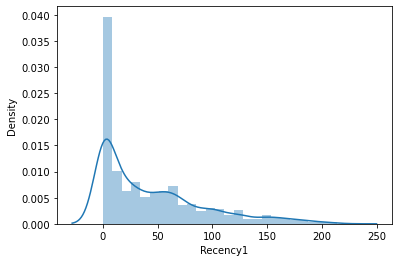

In [12]:
# Recency distribution plot

x = recency['Recency1']

ax = sns.distplot(x)


In [13]:
recency.shape

(3609, 4)

## Age T of Customers
which is how long a customer has been with us; current date we are using - the first time customer took a loan

In [14]:


#get data
age = recency_lite.filter(['clientID', 'DisbursementDate'])
age['DisbursementDate'] = pd.to_datetime(age['DisbursementDate'])
age = age.groupby('clientID').DisbursementDate.min().reset_index(name='First purchase Date')
age.head()

clientID First purchase Date
0  22141758042          2021-04-06
1  22141792815          2021-04-15
2  22141817897          2021-05-08
3  22141869593          2021-05-23
4  22141945095          2021-06-16

In [15]:
import datetime 

age['T'] = datetime.datetime(2021, 9, 30) -age['First purchase Date']
age['T'] = age['T'].dt.days
age.head()

clientID First purchase Date    T
0  22141758042          2021-04-06  177
1  22141792815          2021-04-15  168
2  22141817897          2021-05-08  145
3  22141869593          2021-05-23  130
4  22141945095          2021-06-16  106

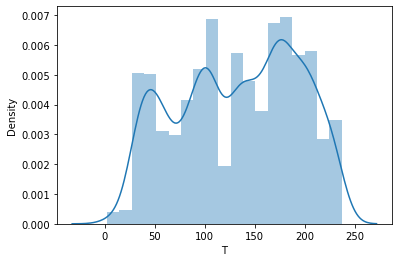

In [16]:
# Recency distribution plot

x = age['T']

ax = sns.distplot(x)


## Frequency

In [17]:
#
recency_lite =recency_lite[~(recency_lite['DisbMonth'].isna())]
recency_lite = recency_lite[recency_lite['Closeddate']<='2021-09-30']
frequency = recency_lite.filter(['clientID', 'LoanId'])

#frequency= frequency[frequency['AccountState'].isin(['CLOSED'])]
#frequency = frequency[frequency['AccountSubstate'].isna()]
#where active, closed, active_in_arrears
frequency = frequency.groupby('clientID').LoanId.count().reset_index(name='Frequency')


In [18]:
frequency.Frequency.max()

18

In [19]:
frequency[frequency['Frequency']==18]

clientID  Frequency
1968  22253135865         18

In [20]:
lite[lite['clientID']==22253135865]

clientID    LoanId     AccountState AccountSubstate  \
4376    22253135865  92050454           CLOSED       WITHDRAWN   
9662    22253135865  92054704           CLOSED       WITHDRAWN   
21928   22253135865  92028878           CLOSED       WITHDRAWN   
21929   22253135865  92028879           CLOSED       WITHDRAWN   
21958   22253135865  92028921           CLOSED       WITHDRAWN   
21972   22253135865  92028947           CLOSED       WITHDRAWN   
36938   22253135865  92057994           CLOSED             NaN   
36957   22253135865  92058007           CLOSED             NaN   
37581   22253135865  92002221           CLOSED             NaN   
41837   22253135865  92117332           CLOSED             NaN   
64165   22253135865  92003584           CLOSED             NaN   
65214   22253135865  92053738           CLOSED             NaN   
75940   22253135865  92018629  CLOSED_REJECTED             NaN   
75944   22253135865  92018636  CLOSED_REJECTED             NaN   
75980   22253135865  92018680           CLOSED             NaN   
84481   22253135865  92000731           CLOSED             NaN   
84622   22253135865  92000991           CLOSED             NaN   
88344   22253135865  92011522           CLOSED       WITHDRAWN   
88748   22253135865  92050455           CLOSED       WITHDRAWN   
89677   22253135865  92001692           CLOSED             NaN   
91202   22253135865  92054854           CLOSED       WITHDRAWN   
104526  22253135865  92026317           CLOSED       WITHDRAWN   
112477  22253135865  92053696           CLOSED             NaN   
116632  22253135865  92098200           CLOSED       WITHDRAWN   
119125  22253135865  92000017           CLOSED             NaN   
120280  22253135865  92019923           CLOSED             NaN   
120552  22253135865  92053573           CLOSED             NaN   
120560  22253135865  92053601           CLOSED       WITHDRAWN   
139555  22253135865  92000124           CLOSED             NaN   
144401  22253135865  92026154           CLOSED       WITHDRAWN   
144405  22253135865  92026161           CLOSED             NaN   
149183  22253135865  92089536           CLOSED             NaN   
149650  22253135865  92044872           CLOSED       WITHDRAWN   
157372  22253135865  92018632  CLOSED_REJECTED             NaN   
157374  22253135865  92018634  CLOSED_REJECTED             NaN   
159849  22253135865  92126418           CLOSED       WITHDRAWN   
161815  22253135865  92058090           CLOSED             NaN   

                      Product LoanType CreationDate DisbursementDate  \
4376          Lite Loan - New      New   2021-06-04              NaN   
9662          Lite Loan - New      New   2021-06-11              NaN   
21928         Lite Loan - New      New   2021-04-23              NaN   
21929         Lite Loan - New      New   2021-04-23              NaN   
21958         Lite Loan - New      New   2021-04-23              NaN   
21972         Lite Loan - New      New   2021-04-23              NaN   
36938         Lite Loan - New      New   2021-06-16       2021-06-16   
36957         Lite Loan - New  Renewal   2021-06-16       2021-06-16   
37581   Nano Loan - NTB Final      New   2021-02-11       2021-02-11   
41837         Lite Loan - New      New   2021-08-31       2021-08-31   
64165         Lite Loan - New      New   2021-02-16       2021-02-17   
65214         Lite Loan - New  Renewal   2021-06-09       2021-06-10   
75940         Lite Loan - New      New   2021-03-25              NaN   
75944         Lite Loan - New      New   2021-03-25              NaN   
75980         Lite Loan - New      New   2021-03-25       2021-03-25   
84481   Nano Loan - NTB Final      New   2021-02-08       2021-02-08   
84622   Nano Loan - NTB Final      New   2021-02-08       2021-02-08   
88344         Lite Loan - New      New   2021-03-03              NaN   
88748         Lite Loan - New      New   2021-06-04              NaN   
89677   Nano Loan - NTB Final      New   2021-02-10       2021

## Monetary

### factoring Unit Economics

### add the monetary fields: get the total amount paid by customer and deduct loan amount

In [21]:

  #MONETARY; only closed accounts
  Lite =lite[lite['AccountState']=='CLOSED']
  Lite = Lite[~(Lite['DisbMonth'].isna())]
  Lite = Lite[Lite['Closeddate']<='2021-09-30']
  
  #confirm loan amount is equiavalent to principalpaid
  Lite['LoanAmount'].equals(other= Lite['principalpaid'])


True

since it's equal, we dont need to include loan amount 

In [22]:


monetary = Lite[['clientID', 'LoanId', 'principalpaid', 'interestpaid', 'feespaid', 'penaltypaid']]
# remove the ids so it wont add to the monetary we are trying to calculate
cols = list(monetary)
cols.remove('clientID')
cols.remove('LoanId')
#get row wise sum
monetary['total'] = monetary[cols].sum(numeric_only = True, axis=1)
# since we added all monetary vlues, let;s subtract the principal which is equivalent to loan amount
monetary['money'] =monetary['total'] - monetary['principalpaid']
# cost of servicing loan accounts of 5 -9k is 737 and of 10-20k 103
monetary['Unit Economics']= np.where(monetary['principalpaid']<=9999,737, 1034 )
monetary['profit']= monetary['money']- monetary['Unit Economics']

monetary = monetary[['clientID', 'LoanId', 'profit']]
monetary['Monetary'] = monetary['profit']
monetary = monetary.groupby('clientID').agg({'Monetary': 'sum'}).reset_index()  


In [23]:
monetary

clientID  Monetary
0     22141758042   3374.00
1     22141792815   4966.00
2     22141817897  10065.33
3     22141869593   1966.00
4     22141945095   8891.98
...           ...       ...
3602  22598831460   7247.00
3603  22600180166   7952.00
3604  22603784657   3566.00
3605  22605794775   7303.10
3606  22611781833   2746.00

[3607 rows x 2 columns]

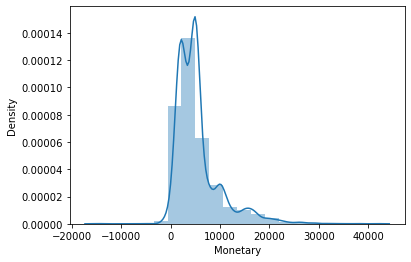

In [24]:
# Monetary distribution plot, taking observations which have monetary value less than 10000

x = monetary['Monetary']

ax = sns.distplot(x, bins=20)

<AxesSubplot:xlabel='Monetary'>

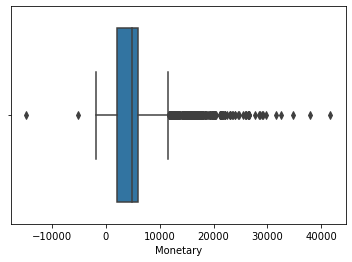

In [25]:
sns.boxplot(monetary['Monetary'])

#### check our most frequent customer

In [26]:
lite[lite['clientID']==22253135865]

clientID    LoanId     AccountState AccountSubstate  \
4376    22253135865  92050454           CLOSED       WITHDRAWN   
9662    22253135865  92054704           CLOSED       WITHDRAWN   
21928   22253135865  92028878           CLOSED       WITHDRAWN   
21929   22253135865  92028879           CLOSED       WITHDRAWN   
21958   22253135865  92028921           CLOSED       WITHDRAWN   
21972   22253135865  92028947           CLOSED       WITHDRAWN   
36938   22253135865  92057994           CLOSED             NaN   
36957   22253135865  92058007           CLOSED             NaN   
37581   22253135865  92002221           CLOSED             NaN   
41837   22253135865  92117332           CLOSED             NaN   
64165   22253135865  92003584           CLOSED             NaN   
65214   22253135865  92053738           CLOSED             NaN   
75940   22253135865  92018629  CLOSED_REJECTED             NaN   
75944   22253135865  92018636  CLOSED_REJECTED             NaN   
75980   22253135865  92018680           CLOSED             NaN   
84481   22253135865  92000731           CLOSED             NaN   
84622   22253135865  92000991           CLOSED             NaN   
88344   22253135865  92011522           CLOSED       WITHDRAWN   
88748   22253135865  92050455           CLOSED       WITHDRAWN   
89677   22253135865  92001692           CLOSED             NaN   
91202   22253135865  92054854           CLOSED       WITHDRAWN   
104526  22253135865  92026317           CLOSED       WITHDRAWN   
112477  22253135865  92053696           CLOSED             NaN   
116632  22253135865  92098200           CLOSED       WITHDRAWN   
119125  22253135865  92000017           CLOSED             NaN   
120280  22253135865  92019923           CLOSED             NaN   
120552  22253135865  92053573           CLOSED             NaN   
120560  22253135865  92053601           CLOSED       WITHDRAWN   
139555  22253135865  92000124           CLOSED             NaN   
144401  22253135865  92026154           CLOSED       WITHDRAWN   
144405  22253135865  92026161           CLOSED             NaN   
149183  22253135865  92089536           CLOSED             NaN   
149650  22253135865  92044872           CLOSED       WITHDRAWN   
157372  22253135865  92018632  CLOSED_REJECTED             NaN   
157374  22253135865  92018634  CLOSED_REJECTED             NaN   
159849  22253135865  92126418           CLOSED       WITHDRAWN   
161815  22253135865  92058090           CLOSED             NaN   

                      Product LoanType CreationDate DisbursementDate  \
4376          Lite Loan - New      New   2021-06-04              NaN   
9662          Lite Loan - New      New   2021-06-11              NaN   
21928         Lite Loan - New      New   2021-04-23              NaN   
21929         Lite Loan - New      New   2021-04-23              NaN   
21958         Lite Loan - New      New   2021-04-23              NaN   
21972         Lite Loan - New      New   2021-04-23              NaN   
36938         Lite Loan - New      New   2021-06-16       2021-06-16   
36957         Lite Loan - New  Renewal   2021-06-16       2021-06-16   
37581   Nano Loan - NTB Final      New   2021-02-11       2021-02-11   
41837         Lite Loan - New      New   2021-08-31       2021-08-31   
64165         Lite Loan - New      New   2021-02-16       2021-02-17   
65214         Lite Loan - New  Renewal   2021-06-09       2021-06-10   
75940         Lite Loan - New      New   2021-03-25              NaN   
75944         Lite Loan - New      New   2021-03-25              NaN   
75980         Lite Loan - New      New   2021-03-25       2021-03-25   
84481   Nano Loan - NTB Final      New   2021-02-08       2021-02-08   
84622   Nano Loan - NTB Final      New   2021-02-08       2021-02-08   
88344         Lite Loan - New      New   2021-03-03              NaN   
88748         Lite Loan - New      New   2021-06-04              NaN   
89677   Nano Loan - NTB Final      New   2021-02-10       2021

In [27]:
recency.shape

(3609, 4)

In [28]:
#Merging three dataframes to create rfm tabley


rfm_table = pd.merge(pd.merge(recency[['clientID', 'Recency1']], frequency[['clientID', 'Frequency']], on='clientID'), pd.merge(monetary[['clientID', 'Monetary']], age[['clientID', 'T']] ,on='clientID'), on='clientID')
rfm_table.rename(columns={'Recency1': 'Recency'}, inplace=True)
rfm_table.head()

clientID  Recency  Frequency  Monetary    T
0  22141758042      146          1   3374.00  177
1  22141792815       61          1   4966.00  168
2  22141817897        0          2  10065.33  145
3  22141869593        0          1   1966.00  130
4  22141945095       39          1   8891.98  106

In [29]:
rfm_table.shape

(3607, 5)

In [30]:
#have a feel of what our frequency looks like
print(rfm_table['Frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(rfm_table['Frequency'] == 1)/float(len(rfm_table))*(100),2)
print("Percentage of customers that requested for Loan only once:", one_time_buyers ,"%")

count    3607.000000
mean        1.338231
std         0.747590
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        18.000000
Name: Frequency, dtype: float64
---------------------------------------
Percentage of customers that requested for Loan only once: 75.91 %


In [31]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = rfm_table[rfm_table['Frequency']>1]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   index     clientID  Recency  Frequency  Monetary    T
0      2  22141817897        0          2  10065.33  145
1      9  22142036004        7          2   9932.00  224
2     13  22142187984       91          2   7752.00  212
3     14  22142221466       42          2  15955.98  168
4     15  22142233047        2          2   2509.60  100
-----------------------------------------
The Number of Returning Customers are:  869


## Deciding RFM Clusters

### some ML functions

In [32]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
rfm_table[rfm_table['Monetary']==41631.34]

clientID  Recency  Frequency  Monetary    T
3383  22433636982        1          3  41631.34  156

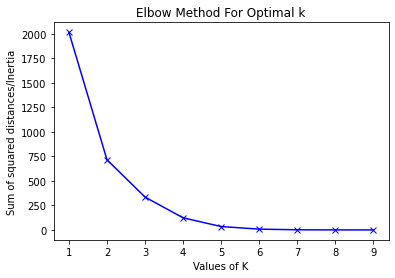

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Frequency']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
KMean= KMeans(n_clusters=4)
KMean.fit(rfm_table)
label=KMean.predict(rfm_table)

print(f'Silhouette Score: {silhouette_score(rfm_table, label)}')

Silhouette Score: 0.5945350627509053


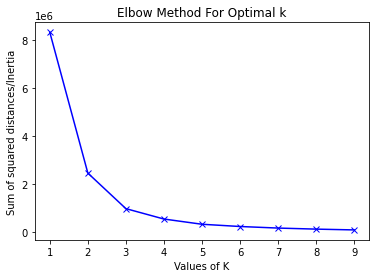

In [39]:
sse={}
tx_recency = rfm_table[['Recency']]
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Recency']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

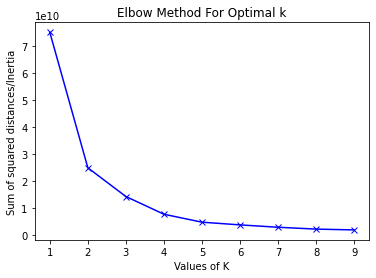

In [40]:
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Monetary']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

First, we decide on the optimum no of clusters. Here, we get 4 as optimum no of clusters which means there will be four cuts for recency, frequency, and monetary each. This is done using the K-means clustering algorithm

In [41]:
#Finding Optimum Clusters

#### Function for ordering clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
  
#Recency Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_table[['Recency']])
rfm_table['RecencyCluster']=kmeans.predict(rfm_table[['Recency']])
rfm_table = order_cluster('RecencyCluster','Recency', rfm_table, False)

#Frequency Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_table[['Frequency']])
rfm_table['FrequencyCluster']=kmeans.predict(rfm_table[['Frequency']])
rfm_table = order_cluster('FrequencyCluster','Frequency', rfm_table, True)

#Monetary Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_table[['Monetary']])
rfm_table['MonetaryCluster']=kmeans.predict(rfm_table[['Monetary']])
rfm_table = order_cluster('MonetaryCluster','Monetary', rfm_table, True)

# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 
  
# Creating Recency Custer Tag Column
c=rfm_table.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()
r1='<='+str(c.iloc[3,2]) 
r2=str(c.iloc[2,1])+' to '+str(c.iloc[2,2]) 
r3=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
r4='>='+str(c.iloc[0,1])
#Create the dictionary 
R ={0 : r4, 1 : r3, 2 : r2, 3:r1} 
rfm_table['RecencyClusterTag']=rfm_table['RecencyCluster'].apply(set_value, args =(R, )) 

# Creating Frequency Custer Tag Column
a=rfm_table.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
f1=str(a.iloc[3,2]) 
f2=str(a.iloc[2,1])+' to '+str(a.iloc[2,2]) 
f3=str(a.iloc[1,1])+' to '+str(a.iloc[1,2]) 
f4=str(a.iloc[0,1])
#Create the dictionary 
F ={0 : f4, 1 : f3, 2 : f2, 3:f1} 
rfm_table['FrequencyClusterTag']=rfm_table['FrequencyCluster'].apply(set_value, args =(F, )) 

# Creating Monetary Custer Tag Column
b=rfm_table.groupby('MonetaryCluster')['Monetary'].agg(['min','max','mean']).reset_index()
m1='<='+str(b.iloc[3,2]) 
m2=str(b.iloc[2,1])+' to '+str(b.iloc[2,2]) 
m3=str(b.iloc[1,1])+' to '+str(b.iloc[1,2]) 
m4='>='+str(b.iloc[0,1])
#Create the dictionary 
M ={0 : m4, 1 : m3, 2 : m2, 3:m1} 
rfm_table['MonetaryClusterTag']=rfm_table['MonetaryCluster'].apply(set_value, args =(M, )) 

rfm_table["FrequencyClusterTag"] = rfm_table["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3, f4]))
rfm_table["MonetaryClusterTag"] = rfm_table["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3, m4]))
rfm_table["RecencyClusterTag"] = rfm_table["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3, r4]))


In [42]:
c

RecencyCluster  min  max        mean
0               0  133  222  164.203252
1               1   78  132  101.969512
2               2   31   77   53.736896
3               3    0   30    7.836498

In [43]:
b

MonetaryCluster       min       max          mean
0                0 -14751.00   3585.00   2008.077541
1                1   3598.00   7783.65   5178.352234
2                2   7793.00  14571.94  10389.065683
3                3  14589.39  41631.34  18749.390864

In [44]:
a

FrequencyCluster  min  max       mean
0                 0    1    1   1.000000
1                 1    2    2   2.000000
2                 2    3    7   3.425532
3                 3   18   18  18.000000

### Data visualizations after deciding RFM clusters


<AxesSubplot:xlabel='RecencyClusterTag', ylabel='count'>

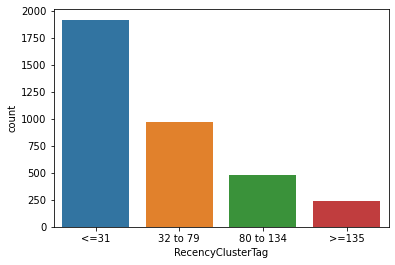

In [1422]:
sns.countplot(x=rfm_table['RecencyClusterTag'])

<AxesSubplot:xlabel='FrequencyClusterTag', ylabel='count'>

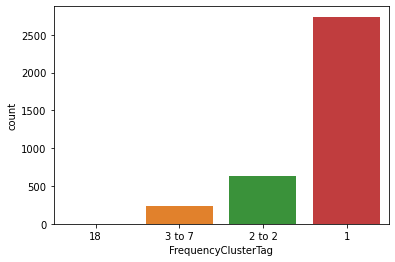

In [1423]:
sns.countplot(x=rfm_table['FrequencyClusterTag'])

<AxesSubplot:xlabel='MonetaryClusterTag', ylabel='count'>

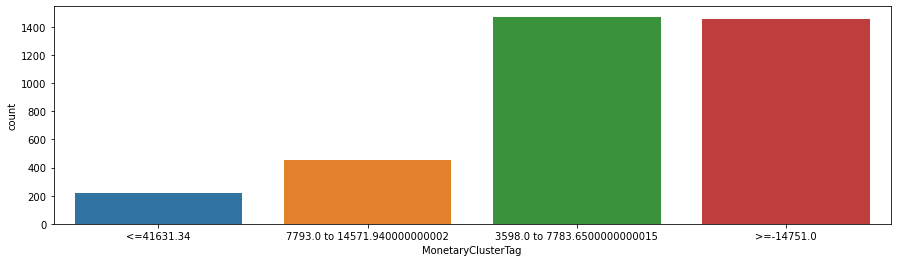

In [1424]:
fig, ax = plt.subplots( figsize = (15,4))
sns.countplot(x=rfm_table['MonetaryClusterTag'])

## Finding a Combined RFM Score

Now the individual RFM scores ranging from 0 to 3 as we decided on 4 clusters are summed up to get a combined RFM score against each customer.

In [45]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values

rfm_table['R'] = rfm_table['RecencyCluster'].map({0:4, 1:3, 2:2, 3:1})
rfm_table['F'] = rfm_table['FrequencyCluster'].map({0:4, 1:3, 2:2, 3:1})
rfm_table['M'] = rfm_table['MonetaryCluster'].map({0:4, 1:3, 2:2, 3:1})
rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042      146          1    3374.0  177               0   
1  22142320284      206          1    1063.0  236               0   
2  22142501225      142          1    2762.0  198               0   
3  22143621326      181          1    2095.0  211               0   
4  22143991962      203          1    1966.0  230               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0             >=133                   1   
1                 0                0             >=133                   1   
2                 0                0             >=133                   1   
3                 0                0             >=133                   1   
4                 0                0             >=133                   1   

  MonetaryClusterTag  R  F  M  
0         >=-14751.0  4  4  4  
1         >=-14751.0  4  4  4  
2         >=-14751.0  4  4  4  
3         >=-14751.0  4  4  4  
4         >=-14751.0  4  4  4

In [46]:
#map the clusters to readable numbers


#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_table['RFMGroup'] = rfm_table.R.map(str) + rfm_table.F.map(str) + rfm_table.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_table['RFMScore'] = rfm_table[['R', 'F', 'M']].sum(axis = 1)
rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042      146          1    3374.0  177               0   
1  22142320284      206          1    1063.0  236               0   
2  22142501225      142          1    2762.0  198               0   
3  22143621326      181          1    2095.0  211               0   
4  22143991962      203          1    1966.0  230               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0             >=133                   1   
1                 0                0             >=133                   1   
2                 0                0             >=133                   1   
3                 0                0             >=133                   1   
4                 0                0             >=133                   1   

  MonetaryClusterTag  R  F  M RFMGroup  RFMScore  
0         >=-14751.0  4  4  4      444        12  
1         >=-14751.0  4  4  4      444        12  
2         >=-14751.0  4  4  4      444        12  
3         >=-14751.0  4  4  4      444        12  
4         >=-14751.0  4  4  4      444        12

In [47]:
rfm_table[rfm_table['Monetary']==-14751.0]

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
1459  22253135865       20         18  -14751.0  237               3   

      FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
1459                 3                0              <=30                  18   

     MonetaryClusterTag  R  F  M RFMGroup  RFMScore  
1459         >=-14751.0  1  1  4      114         6

Most frequent customer isn't profitable

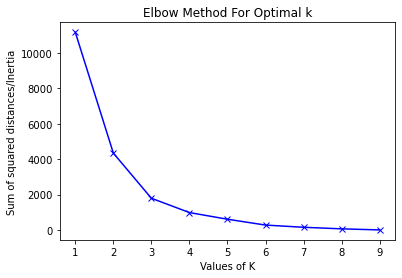

In [1428]:
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['RFMScore']])
 
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

<AxesSubplot:xlabel='RFMScore'>

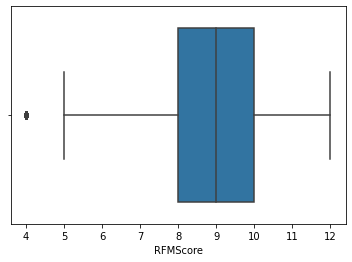

In [1429]:
sns.boxplot(rfm_table.RFMScore)

In [48]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm_table.RFMScore, q = 4, labels = Loyalty_Level)
rfm_table['RFM_Loyalty_Level'] = Score_cuts.values
rfm_table.reset_index().head()

index     clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0      0  22141758042      146          1    3374.0  177               0   
1      1  22142320284      206          1    1063.0  236               0   
2      2  22142501225      142          1    2762.0  198               0   
3      3  22143621326      181          1    2095.0  211               0   
4      4  22143991962      203          1    1966.0  230               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0             >=133                   1   
1                 0                0             >=133                   1   
2                 0                0             >=133                   1   
3                 0                0             >=133                   1   
4                 0                0             >=133                   1   

  MonetaryClusterTag  R  F  M RFMGroup  RFMScore RFM_Loyalty_Level  
0         >=-14751.0  4  4  4      444        12            Bronze  
1         >=-14751.0  4  4  4      444        12            Bronze  
2         >=-14751.0  4  4  4      444        12            Bronze  
3         >=-14751.0  4  4  4      444        12            Bronze  
4         >=-14751.0  4  4  4      444        12            Bronze

In [49]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = rfm_table.query("Monetary < 50000 and Frequency < 20")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver', 
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary

graph = rfm_table.query("Monetary < 50000 and Frequency < 20")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


#Recency Vs Monetary
graph = rfm_table.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


#make individuals plots for loyalty levels
# to get perfectcat of the levels, do a boxplot and see the spread



In [1432]:
rfm_table.Monetary.sum()

19401007.86

In [50]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def groupby_sum(x):
    return x.sum()

def groupby_median(x):
    return x.median()

def percentage(x):
    return round(((x.sum()/ 19401007.86)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_median.__name__ = 'median'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = rfm_table.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean, groupby_median],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean, groupby_median]
})

summary_df=summary_df.reset_index()
summary_df

RFM_Loyalty_Level clientID     Recency        Frequency   Monetary  \
                       count         avg median       avg percentage   
0          Platinum     1506   16.869854      7  1.766268       66.6   
1              Gold     1060   27.524528     17  1.046226       17.9   
2            Silver      587   72.241908     67  1.027257        9.4   
3            Bronze      454  133.742291    131  1.002203        6.2   

                          
           avg    median  
0  8581.198732  6395.840  
1  3271.043085  2786.465  
2  3090.524174  2566.000  
3  2634.976233  2072.500

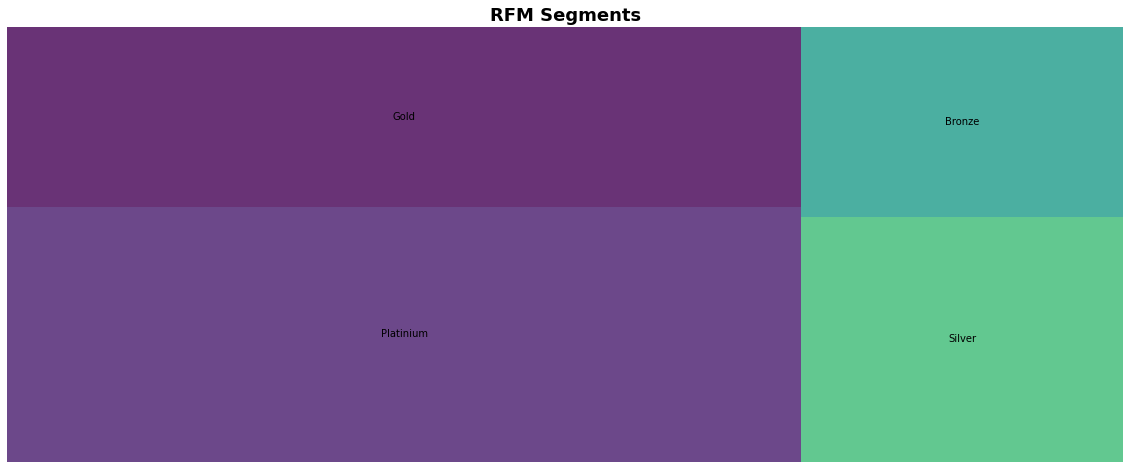

In [51]:
# Dropping a level down
summary_df.columns = summary_df.columns.droplevel(0)
summary_df

import squarify


# monetary values of each of the segments
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=summary_df['count'], 
              label=['Platinium',
                     'Gold',
                     'Silver',
                     'Bronze'], alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

## Profiling


**Champions**: Got a loan recently, often and spend the most

**Loyal customers**: Got loans on a regular basis.

**New customers**: Got a loan most recently, but not often(taken a loan once) with least monetary value.

**Promising**: New customers, avg - high monetary value.

**About to Churn(good)**: Some time since they’ve requested for loan, high frequency and monetary values. Need to bring them back

**About to churn**: Some time since they’ve requested for loan.May not have gotten loan very recently though. 

**Good churned customer**: Used to request for loans frequently with high monetary value but haven’t returned for a long time.

**least profitable churned customers**: Last loan was long back and low frequency, low monetary. May be lost.



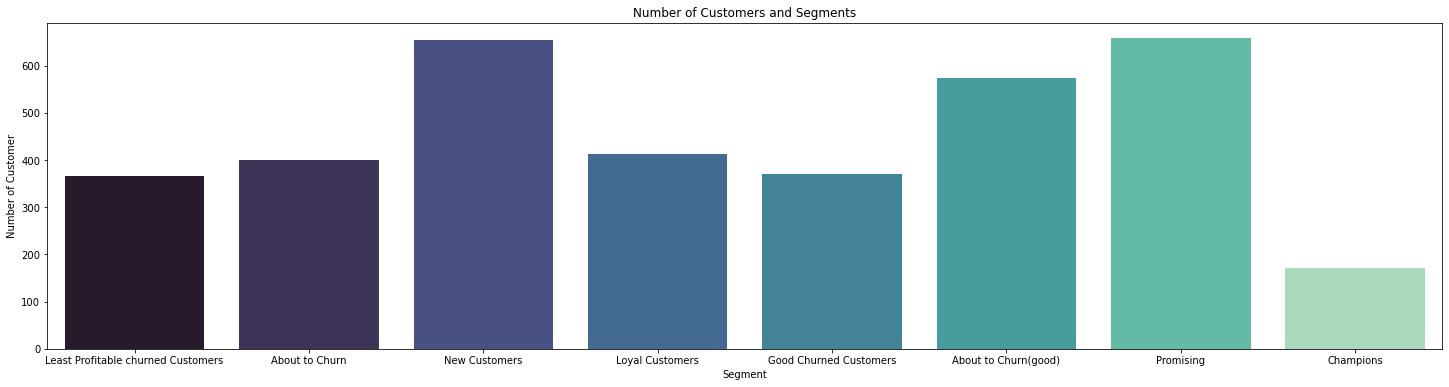

In [52]:
# Create human friendly RFM labels
segt_map = {
    r'1[1-2][1-2]': 'Champions',
    r'14[4]': 'New Customers',
    r'14[1-3]': 'Promising',
    r'1[1-3][1-4]': 'Loyal Customers',
    r'2[1-4][1-3]': 'About to Churn(good)',
    r'2[1-4][4]': 'About to Churn',
    r'[3-4][1-4][1-3]': 'Good Churned Customers',
    r'[3-4][1-4]4': 'Least Profitable churned Customers'

    
}

rfm_table['Segment'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)


plt.figure(figsize=(25,6))
sns.countplot(x=rfm_table['Segment'], palette = 'mako')
plt.title('Number of Customers and Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customer')
plt.show()

In [56]:
sept_df = rfm_table.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean, groupby_median],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean, groupby_median]
})

sept_df=sept_df.reset_index()
sept_df

Segment clientID     Recency        Frequency  \
                                         count         avg median       avg   
0                      About to Churn      399   54.160401     54  1.047619   
1                About to Churn(good)      574   53.442509     53  1.409408   
2                           Champions      172    7.348837      2  3.488372   
3              Good Churned Customers      371  121.110512    111  1.210243   
4  Least Profitable churned Customers      367  124.335150    119  1.046322   
5                     Loyal Customers      412    8.582524      3  2.075243   
6                       New Customers      654    7.548930      3  1.000000   
7                           Promising      658    7.782675      3  1.000000   

    Monetary                           
  percentage           avg     median  
0        4.1   2003.260025   1993.000  
1       20.6   6972.235854   5146.845  
2       15.1  17060.907500  15488.435  
3       11.8   6173.063423   5032.670  
4        3.6   1917.251798   1966.000  
5       18.6   8780.504660   8343.490  
6        6.9   2041.905489   1966.000  
7       19.2   5650.996337   4966.000

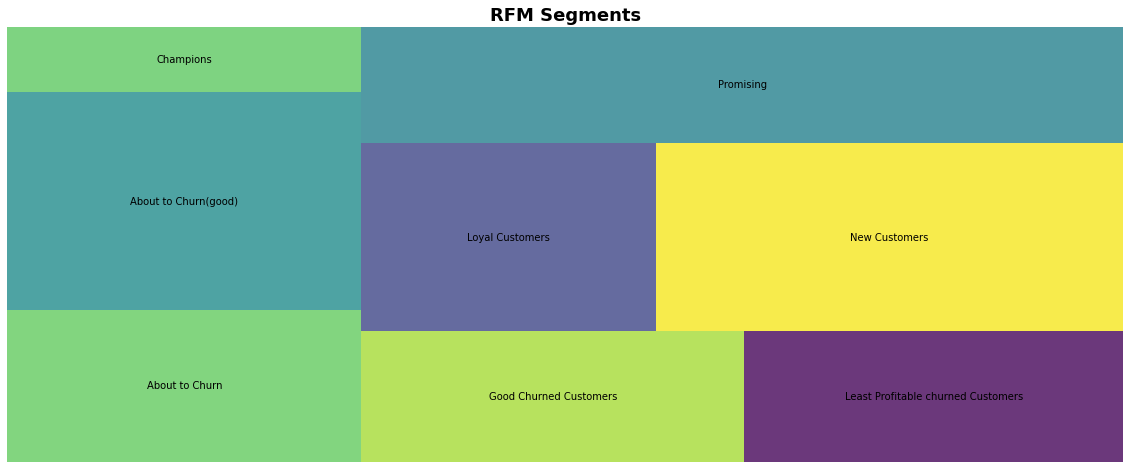

In [64]:
sum_df = sept_df
#Dropping a level down
sum_df.columns = sum_df.columns.droplevel(0)
sum_df


# monetary values of each of the segments
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=sept_df['count'], 
              label=sept_df[''].values, alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [127]:
#let's merge this rfm dataframe with app data

rfm = rfm_table[['clientID', 'Recency', 'Frequency', 'Monetary', 'T']]

Lite = lite.merge(rfm, on='clientID')
Lite = Lite[Lite['AccountState']=='CLOSED']
Lite = Lite[~(Lite['DisbMonth'].isna())]
Lite = Lite.drop_duplicates('clientID', keep='first')
Lite.to_csv('lite&rfm.csv')

In [128]:
rfm_table.RecencyClusterTag.value_counts()

<=30         1896
31 to 77      973
78 to 132     492
>=133         246
Name: RecencyClusterTag, dtype: int64

## now that we understand how to build an RFM model, let's create a function that get's the RFM values for 
**Feb- July**    
**Feb -Aug**   
and compare their characteristics

# RFM function


In [105]:
def RFM(data,  duration):
  '''
  A function that gets the Recency, Frequency and Monetary values based on timeframe specified and get labels based on quantile binning

  '''
  #client id of customers that have been disbursed to
  Data = data[~(data['DisbMonth'].isna())]
  Data = Data[Data['Closeddate']<=duration]
  ids = Data.groupby('clientID').size().reset_index(name='count')
  ids = ids.clientID.values

  #to get their recency value, we need to look for these ids in the main application data and checkc the last time each of the customer interacted with the system

  recency_lite = data[data['clientID'].isin(ids)]
  recency_lite = recency_lite[recency_lite['Closeddate']<=duration]
  recency_lite['Closeddate'] = pd.to_datetime(recency_lite['Closeddate'])
  

  #get RECENCY
  recency= recency_lite.filter(['clientID', 'Closeddate'])
  recency = recency.groupby('clientID').Closeddate.max().reset_index(name='Last Seen Date')
  # since recency is the interval between the last day a customer interacted with the system and today, lets get the difference in day
  #convert string duration to int
  recency['recent'] = datetime.datetime(int(duration[0:4]), int(duration[6:7]), int(duration[8:10])) -recency['Last Seen Date']
  recency['Recent'] = recency['recent'].dt.days

  #get active and active in arrears customers
  act = data[data['AccountState'].isin(['ACTIVE', 'ACTIVE_IN_ARREARS'])]
  act_id  = act.clientID
  rec = recency.clientID
  #find loanid common to both datasets
  active_id = list(set(act_id).intersection(set(rec)))
  recency['Recency']= np.where(recency['clientID'].isin(act_id.values), 0, recency['Recent'])





  #get FREQUENCY; for only accounts disbursed to
  recency_lite =recency_lite[~(recency_lite['DisbMonth'].isna())]
  recency_lite = recency_lite[recency_lite['Closeddate']<=duration]
  frequency = recency_lite.filter(['clientID', 'LoanId', 'DisbMonth'])
  
  frequency = frequency.groupby('clientID').LoanId.count().reset_index(name='Frequency')


  #MONETARY; only closed accounts
  data =data[data['AccountState']=='CLOSED']
  data = data[~(data['DisbMonth'].isna())]
  data = data[data['Closeddate']<=duration]
  monetary = data[['clientID', 'LoanId', 'principalpaid', 'interestpaid', 'feespaid', 'penaltypaid']]


  cols = list(monetary)
  cols.remove('clientID')
  cols.remove('LoanId')
  #get row wise sum
  monetary['total'] = monetary[cols].sum(numeric_only = True, axis=1)
  # since we added all monetary vlues, let;s subtract the principal which is equivalent to loan amount
  monetary['money'] =monetary['total'] - monetary['principalpaid']
  # cost of servicing loan accounts of 5 -9k is 737 and of 10-20k 103
  monetary['Unit Economics']= np.where(monetary['principalpaid']<=9999,737, 1034 )
  monetary['profit']= monetary['money']- monetary['Unit Economics']

  monetary = monetary[['clientID', 'LoanId', 'profit']]
  monetary['Monetary'] = monetary['profit']
  monetary = monetary.groupby('clientID').agg({'Monetary': 'sum'}).reset_index()  


  #Merging the dataframes to create rfm table


  #rfm = pd.merge(pd.merge(recency[['clientID', 'Recency']], frequency[['clientID', 'Frequency']], on='clientID'), pd.merge(monetary[['clientID', 'Monetary']]), on='clientID')
  rfm= pd.merge(pd.merge(recency[['clientID', 'Recency']], frequency[['clientID', 'Frequency']], on='clientID'), monetary[['clientID', 'Monetary']], on='clientID')


  ##Finding Optimum Clusters

  #### Function for ordering clusters
  def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
  
  #Recency Clusters
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(rfm[['Recency']])
  rfm['RecencyCluster']=kmeans.predict(rfm[['Recency']])
  rfm = order_cluster('RecencyCluster','Recency', rfm, False)

  #Frequency Clusters
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(rfm[['Frequency']])
  rfm['FrequencyCluster']=kmeans.predict(rfm[['Frequency']])
  rfm = order_cluster('FrequencyCluster','Frequency', rfm, True)

  #Monetary Clusters
  kmeans = KMeans(n_clusters=4)
  kmeans.fit(rfm[['Monetary']])
  rfm['MonetaryCluster']=kmeans.predict(rfm[['Monetary']])
  rfm = order_cluster('MonetaryCluster','Monetary', rfm, True)

  # Define a function to map the values 
  def set_value(row_number, assigned_value): 
      return assigned_value[row_number] 
  
  # Creating Recency Custer Tag Column
  c=rfm.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()
  r1='<='+str(c.iloc[3,2]) 
  r2=str(c.iloc[2,1])+' to '+str(c.iloc[2,2]) 
  r3=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
  r4='>='+str(c.iloc[0,1])
  #Create the dictionary 
  R ={0 : r4, 1 : r3, 2 : r2, 3:r1} 
  rfm['RecencyClusterTag']=rfm['RecencyCluster'].apply(set_value, args =(R, )) 

  # Creating Frequency Custer Tag Column
  a=rfm.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
  f1=str(a.iloc[3,2]) 
  f2=str(a.iloc[2,1])+' to '+str(a.iloc[2,2]) 
  f3=str(a.iloc[1,1])+' to '+str(a.iloc[1,2]) 
  f4=str(a.iloc[0,1])
  #Create the dictionary 
  F ={0 : f4, 1 : f3, 2 : f2, 3:f1} 
  rfm['FrequencyClusterTag']=rfm['FrequencyCluster'].apply(set_value, args =(F, )) 

  # Creating Monetary Custer Tag Column
  b=rfm.groupby('MonetaryCluster')['Monetary'].agg(['min','max','mean']).reset_index()
  m1='<='+str(b.iloc[3,2]) 
  m2=str(b.iloc[2,1])+' to '+str(b.iloc[2,2]) 
  m3=str(b.iloc[1,1])+' to '+str(b.iloc[1,2]) 
  m4='>='+str(b.iloc[0,1])
  #Create the dictionary 
  M ={0 : m4, 1 : m3, 2 : m2, 3:m1} 
  rfm['MonetaryClusterTag']=rfm['MonetaryCluster'].apply(set_value, args =(M, )) 

  rfm["FrequencyClusterTag"] = rfm["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3, f4]))
  rfm["MonetaryClusterTag"] = rfm["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3, m4]))
  rfm["RecencyClusterTag"] = rfm["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3, r4]))

  #Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values

  rfm['R'] = rfm['RecencyCluster'].map({0:4, 1:3, 2:2, 3:1})
  rfm['F'] = rfm['FrequencyCluster'].map({0:4, 1:3, 2:2, 3:1})
  rfm['M'] = rfm['MonetaryCluster'].map({0:4, 1:3, 2:2, 3:1})

  return rfm

In [106]:
#rfm using quantile binning
july =RFM(lite, '2021-07-31')
july

clientID  Recency  Frequency  Monetary  RecencyCluster  \
0     22141758042       85          1   3374.00               1   
1     22142501225       81          1   2762.00               1   
2     22144134056       75          1   1966.00               1   
3     22145195315       62          1   2686.93               1   
4     22146157167       76          1   1966.00               1   
...           ...      ...        ...       ...             ...   
2660  22202942852       20          3  15431.33               2   
2661  22238691889       32          3  14898.00               2   
2662  22241341232       19          3  14341.33               2   
2663  22323785381       19          4  19930.67               2   
2664  22407761674       20          3  15498.00               2   

      FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                    0                0          51 to 90                   1   
1                    0                0          51 to 90                   1   
2                    0                0          51 to 90                   1   
3                    0                0          51 to 90                   1   
4                    0                0          51 to 90                   1   
...                ...              ...               ...                 ...   
2660                 2                3          19 to 50              3 to 7   
2661                 2                3          19 to 50              3 to 7   
2662                 2                3          19 to 50              3 to 7   
2663                 2                3          19 to 50              3 to 7   
2664                 2                3          19 to 50              3 to 7   

        MonetaryClusterTag  R  F  M  
0               >=-14014.0  3  4  4  
1               >=-14014.0  3  4  4  
2               >=-14014.0  3  4  4  
3               >=-14014.0  3  4  4  
4               >=-14014.0  3  4  4  
...                    ... .. .. ..  
2660  <=31099.339999999997  2  2  1  
2661  <=31099.339999999997  2  2  1  
2662  <=31099.339999999997  2  2  1  
2663  <=31099.339999999997  2  2  1  
2664  <=31099.339999999997  2  2  1  

[2665 rows x 13 columns]

## Profiling


**Champions**: Got a loan recently, often and spend the most

**Loyal customers**: Got loans on a regular basis.

**New customers**: Got a loan most recently, but not often.

**Promising**: Recent customers, high monetary value.

**About to Churn(good)**: Some time since they’ve requested for loan, high frequency and monetary values. Need to bring them back

**About to churn**: Some time since they’ve requested for loan.May not have gotten loan very recently though. 

**Good churned customer**: Used to request for loans frequently with high monetary value but haven’t returned for a long time.

**least profitable churned customers**: Last loan was long back and low frequency, low monetary. May be lost.

In [107]:
def Segment(data):
  # Create human friendly RFM labels
  # Create human friendly RFM labels
  segt_map = {
      r'1[1-2][1-2]': 'Champions',
      r'14[4]': 'New Customers',
      r'14[1-3]': 'Promising',
      r'1[1-3][1-4]': 'Loyal Customers',
      r'2[1-4][1-3]': 'About to Churn(good)',
      r'2[1-4][4]': 'About to Churn',
      r'[3-4][1-4][1-3]': 'Good Churned Customers',
      r'[3-4][1-4]4': 'Least Profitable churned Customers'

      
  }

  data['Segment'] = data['R'].map(str) + data['F'].map(str) + data['M'].map(str)
  data['Segment'] = data['Segment'].replace(segt_map, regex=True)
  return data
july = Segment(july)


In [124]:
rfm_table.RecencyClusterTag.value_counts()

<=30         1896
31 to 77      973
78 to 132     492
>=133         246
Name: RecencyClusterTag, dtype: int64

## July

In [108]:
# merge labels with application data
july_rfm =july[['clientID','Recency', 'Frequency', 'Monetary', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = lite[~(lite['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-07-31']

appdata.drop(['LoanId'], axis=1, inplace=True)


app_july = july_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app_july.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)


Get the number of closed and disbursed accounts for customers we've seen from feb - aug

In [109]:
def custcount(df, Class, start, stop, month):

  # get the number of customers that applied for loans in Aug
  test =df[(df['DisbursementDate']>start) & (df['DisbursementDate']<=stop)]
  test = test[~(test['DisbMonth'].isna())]
  #test =test[test['AccountState']=='CLOSED']
  augtest = july_rfm.merge(test, on='clientID')
  #loyalty =augtest.groupby(Class).clientID.count().reset_index()
  loyalty = augtest.groupby(Class).agg({'clientID': 'count'}).reset_index()
  loyalty.rename(columns={'clientID': f"{month}Disb"}, inplace=True)


  # get the number of customers that closed their loans in Aug, only for existing customers
  test =df[(df['Closeddate']>start) & (df['Closeddate']<=stop)]
  test = test[~(test['DisbMonth'].isna())]
  #test =test[test['AccountState']=='CLOSED']
  augtest1 = july_rfm.merge(test, on='clientID')
  #loyalty =augtest.groupby(Class).clientID.count().reset_index()
  loyalty1 = augtest1.groupby(Class).agg({'clientID': 'count'}).reset_index()
  loyalty1.rename(columns={'clientID': f"{month}Closed"}, inplace=True)
  final = loyalty1.merge(loyalty, on=Class)

  return final

final =custcount(lite, 'Segment', '2021-07-31', '2021-08-31', 'Aug')
final


Segment  AugClosed  AugDisb
0                      About to Churn         16        9
1                About to Churn(good)         39       29
2                           Champions          9       27
3              Good Churned Customers         10       12
4  Least Profitable churned Customers          4        4
5                     Loyal Customers         40       70
6                       New Customers         54      101
7                           Promising         51      126

In [110]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return round(x.mean(),2)

def groupby_count(x):
    return x.nunique()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 12347314.54)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

def groupby_median(x):
    return (x.median())


    

groupby_mean.__name__ = 'avg'
groupby_median.__name__ = 'median'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'


In [111]:

#get count of aug customers
final = custcount(lite, 'Segment', '2021-07-31', '2021-08-31', 'Aug')

summary_df = app_july.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean, groupby_median],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean, groupby_median],
    'Age' : [groupby_mean, groupby_median],
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summary_df=summary_df.reset_index()
#merge with aug
summary =summary_df.merge(final, on='Segment')
#pr of customers that returned for a loan in Aug
summary['Pr(Returned)'] = round((summary['AugDisb']/ summary[('clientID', 'count')]), 3)

julysummarysegment = summary
julysummarysegment

Segment                         (Segment, )  \
0                      About to Churn                      About to Churn   
1                About to Churn(good)                About to Churn(good)   
2                           Champions                           Champions   
3              Good Churned Customers              Good Churned Customers   
4  Least Profitable churned Customers  Least Profitable churned Customers   
5                     Loyal Customers                     Loyal Customers   
6                       New Customers                       New Customers   
7                           Promising                           Promising   

   (clientID, count)  (Recency, avg)  (Recency, median)  (Frequency, avg)  \
0                258           32.93               33.0              1.03   
1                354           32.63               32.0              1.32   
2                 60            3.43                1.0              3.33   
3                304           83.55               79.5              1.14   
4                249           85.96               84.0              1.04   
5                272            4.59                2.0              2.09   
6                537            4.91                3.0              1.00   
7                631            4.48                3.0              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Monetary, median)  (Age, avg)  \
0                     3.9          1865.76            1966.000       33.60   
1                    18.3          6374.99            5086.830       34.53   
2                     7.0         14379.82           14898.000       35.38   
3                    14.2          5764.85            4966.000       35.46   
4                     3.6          1793.86            1966.000       34.21   
5                    17.2          7800.71            7292.045       33.92   
6                     8.2          1885.60            1966.000       33.27   
7                    27.3          5345.09            4966.000       34.83   

   (Age, median)  (LoanAmount, avg)  (TimeEmploymentMM, avg)  \
0           33.5            9805.43                    66.13   
1           34.0           17552.82                    70.85   
2           34.0           16690.00                    76.32   
3           35.0           18166.30                    74.74   
4           33.0           10030.52                    68.87   
5           33.0           15068.38                    66.62   
6           32.0            9611.36                    63.76   
7           34.0           18608.24                    71.59   

   (TotalTimeAtAddress, avg)  (Income, avg)  AugClosed  AugDisb  Pr(Returned)  
0                     179.93      125034.93         16        9         0.035  
1                     173.49      192949.48         39       29         0.082  
2                     185.15      298509.39          9       27         0.450  
3                     158.53      220109.96         10       12         0.039  
4                     178.58      163749.47          4        4         0.016  
5                     180.65      183973.78         40       70         0.257  
6                     165.55      112767.30         54      101         0.188  
7                     185.76      187273.38         51      126         0.200

## August

In [112]:
august = RFM(lite, '2021-08-31')
#segments
aug_rfm=Segment(august)
aug_rfm.head()

clientID  Recency  Frequency  Monetary  RecencyCluster  \
0  22141758042      116          1    3374.0               0   
1  22142320284      176          1    1063.0               0   
2  22142501225      112          1    2762.0               0   
3  22143621326      151          1    2095.0               0   
4  22143991962      173          1    1966.0               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0             >=106                   1   
1                 0                0             >=106                   1   
2                 0                0             >=106                   1   
3                 0                0             >=106                   1   
4                 0                0             >=106                   1   

  MonetaryClusterTag  R  F  M                             Segment  
0         >=-14014.0  4  4  4  Least Profitable churned Customers  
1         >=-14014.0  4  4  4  Least Profitable churned Customers  
2         >=-14014.0  4  4  4  Least Profitable churned Customers  
3         >=-14014.0  4  4  4  Least Profitable churned Customers  
4         >=-14014.0  4  4  4  Least Profitable churned Customers

In [113]:
# merge labels with application data
aug_rfm =aug_rfm[['clientID','Recency', 'Frequency', 'Monetary', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = lite[~(lite['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-08-31']

appdata.drop(['LoanId'], axis=1, inplace=True)


app_aug = aug_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app_aug.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)


In [114]:
august.Monetary.sum()

14858553.48

In [115]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return round(x.mean(),2)

def groupby_count(x):
    return x.nunique()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 14858553.48)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

def groupby_median(x):
    return (x.median())


    

groupby_mean.__name__ = 'avg'
groupby_median.__name__ = 'median'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'

In [116]:
#get sept customercount
final =custcount(lite, 'Segment', '2021-08-31', '2021-09-30', 'Sept')

summary_df = app_aug.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean, groupby_median],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean, groupby_median],
    'Age' : [groupby_mean, groupby_median],
    'LoanAmount' : [groupby_mean, groupby_median],
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean, groupby_median]
   
})

summary_df=summary_df.reset_index()
#summary_df['Pr of returning'] = loyalty['clientID'].values /summary_df['clientID'].values
summary =summary_df.merge(final, on='Segment')
summary['Pr(Returned)'] = round((summary['SeptDisb']/ summary[('clientID', 'count')]), 3)

augsummarysegment = summary

augsummarysegment

Segment             (Segment, )  (clientID, count)  \
0          About to Churn          About to Churn                417   
1    About to Churn(good)    About to Churn(good)                593   
2               Champions               Champions                 75   
3  Good Churned Customers  Good Churned Customers                374   
4         Loyal Customers         Loyal Customers                272   
5           New Customers           New Customers                496   
6               Promising               Promising                477   

   (Recency, avg)  (Recency, median)  (Frequency, avg)  \
0           34.72               34.0              1.08   
1           34.01               33.0              1.45   
2            2.60                0.0              3.37   
3           94.84               86.5              1.19   
4            4.14                0.0              2.03   
5            4.59                0.0              1.00   
6            4.80                0.0              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Monetary, median)  (Age, avg)  \
0                     5.5          1963.40            1966.000       33.97   
1                    27.9          6995.92            5099.330       34.65   
2                     6.9         13685.57           14368.000       35.93   
3                    15.6          6182.23            5032.670       34.88   
4                    14.5          7924.07            7297.595       33.57   
5                     6.7          2008.30            1966.000       33.18   
6                    18.1          5636.95            4966.000       34.08   

   (Age, median)  (LoanAmount, avg)  (LoanAmount, median)  \
0           33.0           10048.44                9800.0   
1           34.0           18036.59               20000.0   
2           35.0           15993.33               19200.0   
3           34.0           18158.44               20000.0   
4           33.0           15325.37               15650.0   
5           33.0           10104.44               10000.0   
6           33.0           18845.70               20000.0   

   (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  (Income, avg)  \
0                    65.66                     175.91      133777.12   
1                    69.01                     181.99      215477.51   
2                    81.40                     206.72      185210.44   
3                    72.78                     167.32      209755.64   
4                    65.87                     158.88      174437.91   
5                    63.36                     179.43      124614.33   
6                    67.77                     179.44      179301.01   

   (Income, median)  SeptClosed  SeptDisb  Pr(Returned)  
0           90000.0           8         4         0.010  
1          150000.0          38        10         0.017  
2          137000.0          26        12         0.160  
3          150000.0          16         2         0.005  
4          106270.5          46        23         0.085  
5           80000.0          59        41         0.083  
6          150000.0          88        37         0.078

## September

In [117]:
sept = RFM(lite, '2021-09-30')
#segments
sep_rfm=Segment(sept)
# merge labels with application data
sep_rfm =sep_rfm[['clientID','Recency', 'Frequency', 'Monetary', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = lite[~(lite['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-09-30']

appdata.drop(['LoanId'], axis=1, inplace=True)


app_sep = sep_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app_sep.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)

In [118]:


summary_df = app_sep.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'NoChildren' : groupby_mean,
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summarysegment=summary_df.reset_index()
summarysegment

Segment clientID Recency Frequency   Monetary  \
                                         count     avg       avg percentage   
0                      About to Churn      396   54.93      1.05        5.3   
1                About to Churn(good)      564   54.17      1.40       26.2   
2                           Champions      175    7.75      3.49       20.1   
3              Good Churned Customers      367  121.58      1.20       15.2   
4  Least Profitable churned Customers      362  124.98      1.05        4.7   
5                     Loyal Customers      418    8.90      2.07       24.7   
6                       New Customers      661    7.80      1.00        9.1   
7                           Promising      664    7.99      1.00       25.2   

               Age NoChildren LoanAmount TimeEmploymentMM TotalTimeAtAddress  \
        avg    avg        avg        avg              avg                avg   
0   1996.77  33.53       1.07    9991.92            62.58             165.78   
1   6892.43  34.59       1.26   18029.79            68.37             183.14   
2  17099.31  35.83       1.35   17747.43            72.61             158.32   
3   6166.94  34.97       1.22   18059.13            74.66             175.72   
4   1920.10  33.76       0.97   10128.18            68.66             175.63   
5   8784.29  34.06       1.18   16964.25            67.50             174.28   
6   2042.64  33.30       1.06   10138.73            65.14             186.85   
7   5647.92  34.04       1.25   18777.86            68.30             176.89   

      Income  
         avg  
0  134034.05  
1  205410.41  
2  226002.96  
3  213943.71  
4  138874.75  
5  184621.31  
6  123168.72  
7  479118.41

## Loyalty Levels; Month-on-Month

### July 

In [816]:
julysummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                771           15.38   
1              Gold                  Gold                897           23.56   
2            Silver                Silver                465           48.68   
3            Bronze                Bronze                532           70.08   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.77                    48.9          7823.53       34.62   
1              1.02                    30.2          4152.05       34.33   
2              1.00                    12.4          3299.68       34.43   
3              1.00                     8.6          1986.15       33.63   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           16984.57                    72.09                     188.88   
1           15180.38                    67.37                     169.43   
2           14173.02                    70.50                     179.04   
3           10271.43                    66.42                     161.64   

   (Income, avg)  AugClosed  AugDisb  Pr(Returned)  
0      196218.32         96      185         0.240  
1      170990.09         77      125         0.139  
2      166370.17         27       41         0.088  
3      137034.93         23       27         0.051

 ### August

In [817]:
augsummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                914           25.31   
1              Gold                  Gold               1001           33.58   
2            Silver                Silver                541           62.91   
3            Bronze                Bronze                609           88.03   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.90                    51.1          8328.09       34.21   
1              1.02                    28.5          4246.93       34.13   
2              1.00                    12.1          3337.90       34.03   
3              1.00                     8.3          2025.01       34.02   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           16681.18                    69.09                     177.79   
1           15541.36                    64.62                     174.22   
2           14250.09                    70.20                     184.48   
3           10283.18                    69.70                     172.81   

   (Income, avg)  SeptClosed  SeptDisb  Pr(Returned)  
0      193358.24         146        60         0.066  
1      179656.35          93        45         0.045  
2      152158.15          26        13         0.024  
3      130942.10          19        11         0.018

### September

In [818]:
sepsummarylevel

RFM_Loyalty_Level clientID Recency Frequency   Monetary              Age  \
                       count     avg       avg percentage       avg    avg   
0          Platinum     1040   32.99      2.15       53.6  10024.86  34.35   
1              Gold     1101   33.35      1.03       24.5   4324.90  34.09   
2            Silver      616   65.96      1.00       10.8   3408.65  33.76   
3            Bronze      850  111.61      1.00       11.1   2538.62  34.00   

  NoChildren LoanAmount TimeEmploymentMM TotalTimeAtAddress     Income  
         avg        avg              avg                avg        avg  
0       1.21   17049.96            67.98             178.63  191606.37  
1       1.23   15495.64            67.99             182.02  353039.63  
2       1.12   14377.60            62.84             174.54  164750.63  
3       1.04   11926.47            71.37             170.39  146513.75

In [100]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [874]:
# AddresLGA
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [879]:
df3= app.groupby('RFM_Loyalty_Level')['LoanAmount'].describe()

## K-means Clustering; Month-on-Month

In [400]:
julysummarycluster

Cluster  (Cluster, )  (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0        0            0                 35           53.60              1.77   
1        1            1                756            5.75              1.06   
2        2            2                605           24.94              3.21   
3        3            3               1269           56.42              1.03   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (NoChildren, avg)  \
0                     0.0             1.51       33.37               0.89   
1                    25.4          3886.79       34.20               1.08   
2                    67.6         12936.28       35.02               1.33   
3                    41.4          3777.75       34.02               1.14   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           12254.29                    65.46                     188.14   
1           14311.77                    68.45                     185.72   
2           15644.46                    71.91                     185.58   
3           14226.36                    68.23                     163.59   

   (Income, avg)  count of Aug customers  Pr(Returned ff mnt)  
0      153258.17                       5                0.143  
1      154309.32                     155                0.205  
2      195932.91                     127                0.210  
3      168925.02                      91                0.072

In [401]:
augsummarycluster

Cluster  (Cluster, )  (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0        0            0                524            7.28              1.05   
1        1            1               1891           61.80              1.00   
2        2            2                608           34.48              2.31   
3        3            3                 42           65.26              1.55   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (NoChildren, avg)  \
0                    14.0          3974.77       33.60               1.16   
1                    48.6          3828.44       34.23               1.15   
2                    37.4          9177.02       34.21               1.18   
3                     0.0             2.19       33.86               0.93   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           14162.02                    68.26                     186.56   
1           14489.14                    67.98                     174.34   
2           15534.70                    68.09                     176.33   
3           12150.00                    60.48                     173.67   

   (Income, avg)  count of Sept customers  Pr(Returned ff mnt)  
0      163613.68                       51                0.097  
1      164838.85                      168                0.089  
2      189570.50                      139                0.229  
3      141048.48                        4                0.095

In [402]:
sepsummarycluster

Cluster clientID Recency Frequency   Monetary              Age NoChildren  \
             count     avg       avg percentage       avg    avg        avg   
0       0     2027   80.69      1.00       39.9   3829.87  33.96       1.12   
1       1      706    8.25      1.05       14.9   4090.64  34.20       1.24   
2       2      831   40.35      2.40       45.2  10582.29  34.29       1.19   
3       3       43   84.02      1.56        0.0      2.16  34.49       1.09   

  LoanAmount TimeEmploymentMM TotalTimeAtAddress     Income  
         avg              avg                avg        avg  
0   14392.60            67.68             174.93  166265.93  
1   14483.57            69.06             183.46  439015.91  
2   16676.48            67.65             177.01  193682.34  
3   12311.63            64.51             170.51  141256.65

## Segment

In [92]:
julysummarysegment

Segment                         (Segment, )  \
0                      About to Churn                      About to Churn   
1                About to Churn(good)                About to Churn(good)   
2                           Champions                           Champions   
3              Good Churned Customers              Good Churned Customers   
4  Least Profitable churned Customers  Least Profitable churned Customers   
5                     Loyal Customers                     Loyal Customers   
6                       New Customers                       New Customers   
7                           Promising                           Promising   

   (clientID, count)  (Recency, avg)  (Recency, median)  (Frequency, avg)  \
0                245           33.67               34.0              1.03   
1                328           33.71               33.0              1.31   
2                 64            4.41                1.0              3.33   
3                304           83.55               79.5              1.14   
4                249           85.96               84.0              1.04   
5                277            4.85                3.0              2.09   
6                549            5.22                3.0              1.00   
7                649            4.88                3.0              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Monetary, median)  (Age, avg)  \
0                     3.7          1845.85             1963.00       33.42   
1                    16.7          6305.32             5086.83       34.52   
2                     7.5         14402.66            14898.00       35.48   
3                    14.2          5764.85             4966.00       35.46   
4                     3.6          1793.86             1966.00       34.21   
5                    17.4          7774.54             7292.00       33.92   
6                     8.4          1892.27             1966.00       33.38   
7                    28.1          5352.03             4966.00       34.80   

   (Age, median)  (LoanAmount, avg)  (TimeEmploymentMM, avg)  \
0           33.0            9755.51                    64.66   
1           34.0           17572.87                    70.11   
2           34.0           16814.06                    79.31   
3           35.0           18166.30                    74.74   
4           33.0           10030.52                    68.87   
5           33.0           15017.69                    66.92   
6           32.0            9641.17                    64.52   
7           34.0           18587.98                    71.47   

   (TotalTimeAtAddress, avg)  (Income, avg)  AugClosed  AugDisb  Pr(Returned)  
0                     170.89      124841.11         15        8         0.033  
1                     175.38      190502.72         33       25         0.076  
2                     184.59      285602.55         11       29         0.453  
3                     158.53      220109.96         10       12         0.039  
4                     178.58      163749.47          4        4         0.016  
5                     180.06      183071.73         41       71         0.256  
6                     170.09      113240.40         55      102         0.186  
7                     184.49      189538.87         54      127         0.196

In [93]:
augsummarysegment

Segment             (Segment, )  (clientID, count)  \
0          About to Churn          About to Churn                421   
1    About to Churn(good)    About to Churn(good)                614   
2               Champions               Champions                 74   
3  Good Churned Customers  Good Churned Customers                378   
4         Loyal Customers         Loyal Customers                266   
5           New Customers           New Customers                482   
6               Promising               Promising                459   

   (Recency, avg)  (Recency, median)  (Frequency, avg)  \
0           33.72               33.0              1.08   
1           33.26               33.0              1.45   
2            2.38                0.0              3.36   
3           94.42               85.5              1.19   
4            3.80                0.0              2.03   
5            4.17                0.0              1.00   
6            4.24                0.0              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Monetary, median)  (Age, avg)  \
0                     5.6          1967.76            1993.000       33.97   
1                    29.0          7017.16            5099.330       34.60   
2                     6.8         13607.37           14256.500       35.96   
3                    15.7          6183.06            5032.670       34.89   
4                    14.2          7910.28            7297.595       33.68   
5                     6.5          2011.84            1966.000       33.17   
6                    17.3          5608.95            4966.000       34.04   

   (Age, median)  (LoanAmount, avg)  (LoanAmount, median)  \
0           33.0           10098.10                9800.0   
1           34.0           18078.01               20000.0   
2           35.0           15950.00               19250.0   
3           34.0           18157.03               20000.0   
4           33.0           15257.14               15400.0   
5           32.0           10108.92               10000.0   
6           33.0           18828.76               20000.0   

   (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  (Income, avg)  \
0                    65.19                     175.07      132269.28   
1                    68.78                     181.39      214156.62   
2                    81.00                     207.86      186348.42   
3                    72.74                     168.79      208620.66   
4                    65.96                     158.65      175771.10   
5                    63.59                     180.89      126210.38   
6                    68.03                     178.76      179075.34   

   (Income, median)  SeptClosed  SeptDisb  Pr(Returned)  
0           86000.0           8         2         0.005  
1          150000.0          36        10         0.016  
2          141325.0          26        12         0.162  
3          150000.0          16         2         0.005  
4          106270.5          47        23         0.086  
5           82500.0          59        43         0.089  
6          150000.0          89        37         0.081

In [96]:
#sept

summarysegment

Segment clientID Recency Frequency   Monetary  \
                                         count     avg       avg percentage   
0                      About to Churn      403   55.35      1.05        5.4   
1                About to Churn(good)      569   54.39      1.40       26.3   
2                           Champions      175    7.75      3.49       20.1   
3              Good Churned Customers      362  122.17      1.21       15.1   
4  Least Profitable churned Customers      355  125.88      1.04        4.6   
5                     Loyal Customers      418    8.90      2.07       24.7   
6                       New Customers      661    7.80      1.00        9.1   
7                           Promising      664    7.99      1.00       25.2   

               Age NoChildren LoanAmount TimeEmploymentMM TotalTimeAtAddress  \
        avg    avg        avg        avg              avg                avg   
0   1997.47  33.50       1.07    9960.55            62.72             168.13   
1   6875.86  34.62       1.26   18047.10            68.60             183.27   
2  17099.31  35.83       1.35   17747.43            72.61             158.32   
3   6182.98  34.93       1.22   18032.32            74.39             175.41   
4   1917.79  33.80       0.96   10166.48            68.62             173.16   
5   8784.29  34.06       1.18   16964.25            67.50             174.28   
6   2042.64  33.30       1.06   10138.73            65.14             186.85   
7   5647.92  34.04       1.25   18777.86            68.30             176.89   

      Income  
         avg  
0  133375.89  
1  206587.82  
2  226002.96  
3  212210.89  
4  139717.35  
5  184621.31  
6  123168.72  
7  479118.41

In [98]:
df1=app_july.groupby('Segment').AddresLGA.describe()
df2= app_aug.groupby('Segment').AddresLGA.describe()
df3=app_sep.groupby('Segment').AddresLGA.describe()

In [101]:
#AddresLGA
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [102]:
#EmployerLGA

df1=app_july.groupby('Segment').EmployerLGA.describe()
df2= app_aug.groupby('Segment').EmployerLGA.describe()
df3=app_sep.groupby('Segment').EmployerLGA.describe()
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [103]:
#BusinessSector
df1=app_july.groupby('Segment').BusinessSector.describe()
df2= app_aug.groupby('Segment').BusinessSector.describe()
df3=app_sep.groupby('Segment').BusinessSector.describe()
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [121]:
df3 =app_sep.groupby('Segment')['AgeGroup'].describe()
df3

count unique    top freq
Segment                                                    
About to Churn                       392      7  25-30  100
About to Churn(good)                 562      7  30-35  173
Champions                            174      7  30-35   52
Good Churned Customers               367      7  30-35   95
Least Profitable churned Customers   359      7  25-30   94
Loyal Customers                      415      7  30-35  101
New Customers                        656      7  30-35  165
Promising                            661      7  30-35  188

In [122]:
#Age Group
df1=app_july.groupby('Segment').AgeGroup.describe()
df2= app_aug.groupby('Segment').AgeGroup.describe()
df3=app_sep.groupby('Segment').AgeGroup.describe()

display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [623]:
#To understand the gender divide of each cluster
data2 = pd.DataFrame(app.groupby(['Segment','Gender'])['Gender'].count())
data2

Gender
Segment                            Gender        
About to Churn                     FEMALE      39
                                   MALE       135
About to Churn(good)               FEMALE     115
                                   MALE       364
Champions                          FEMALE      62
                                   MALE       198
Good Churned Customers             FEMALE     114
                                   MALE       360
Least Profitable churned Customers FEMALE      47
                                   MALE       144
Loyal Customers                    FEMALE      13
                                   MALE        39
New Customers                      FEMALE      67
                                   MALE       233
Promising                          FEMALE     165
                                   MALE       570

# K means Clustering
to determine optimum clusters and observe their characteristics

In [1318]:
#remove outliers
rfm_table = rfm_table[rfm_table['Monetary']<rfm_table['Monetary'].quantile(0.99)]


#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_table['Recency'] = [handle_neg_n_zero(x) for x in rfm_table.Recency]
rfm_table['Monetary'] = [handle_neg_n_zero(x) for x in rfm_table.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_table[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

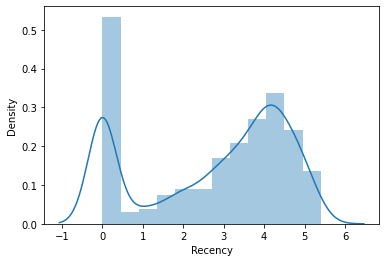

In [1319]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

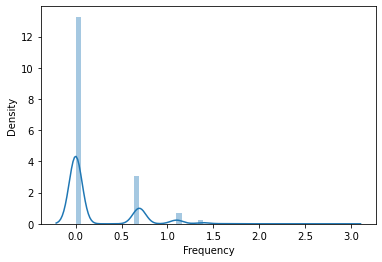

In [1321]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data['Frequency']
ax = sns.distplot(Frequency_Plot)

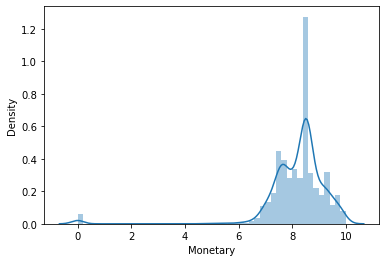

In [1322]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data['Monetary']
ax = sns.distplot(Monetary_Plot)

In [1323]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_table.index, columns = Log_Tfd_Data.columns)

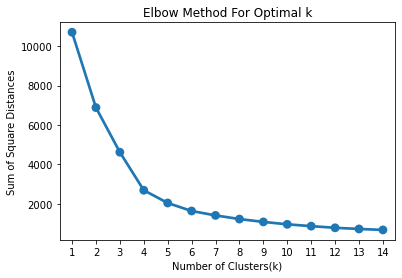

In [1324]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [1325]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
rfm_table['Cluster'] = KMean_clust.labels_
rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042      146          1    3374.0  177               0   
1  22142320284      206          1    1063.0  236               0   
2  22142501225      142          1    2762.0  198               0   
3  22143621326      181          1    2095.0  211               0   
4  22143991962      203          1    1966.0  230               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0             >=135                   1   
1                 0                0             >=135                   1   
2                 0                0             >=135                   1   
3                 0                0             >=135                   1   
4                 0                0             >=135                   1   

  MonetaryClusterTag  R  F  M RFMGroup  RFMScore RFM_Loyalty_Level  \
0         >=-14751.0  4  4  4      444        12            Bronze   
1         >=-14751.0  4  4  4      444        12            Bronze   
2         >=-14751.0  4  4  4      444        12            Bronze   
3         >=-14751.0  4  4  4      444        12            Bronze   
4         >=-14751.0  4  4  4      444        12            Bronze   

                              Segment  Cluster  
0  Least Profitable churned Customers        2  
1  Least Profitable churned Customers        2  
2  Least Profitable churned Customers        2  
3  Least Profitable churned Customers        2  
4  Least Profitable churned Customers        2

In [1326]:
rfm_table.Cluster.value_counts()

2    1821
1     880
0     826
3      43
Name: Cluster, dtype: int64

<Figure size 504x504 with 0 Axes>

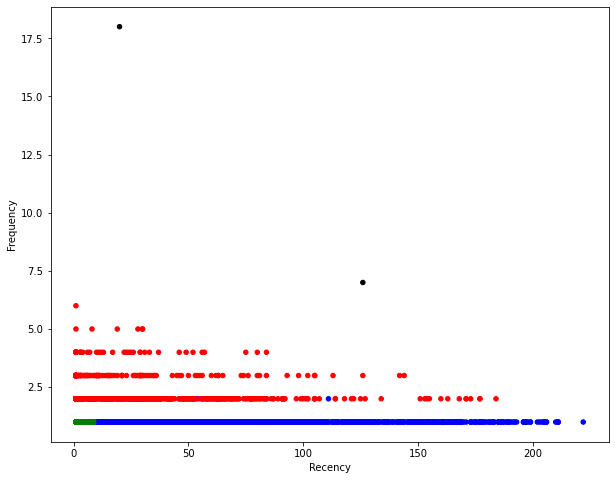

In [1327]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency 
#red=0, green=1, blue=2, black=3
Colors = ["red", "green", "blue", 'black']
rfm_table['Color'] =rfm_table['Cluster'].map(lambda p: Colors[p])
ax =rfm_table.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c =rfm_table['Color']
)

<Figure size 504x504 with 0 Axes>

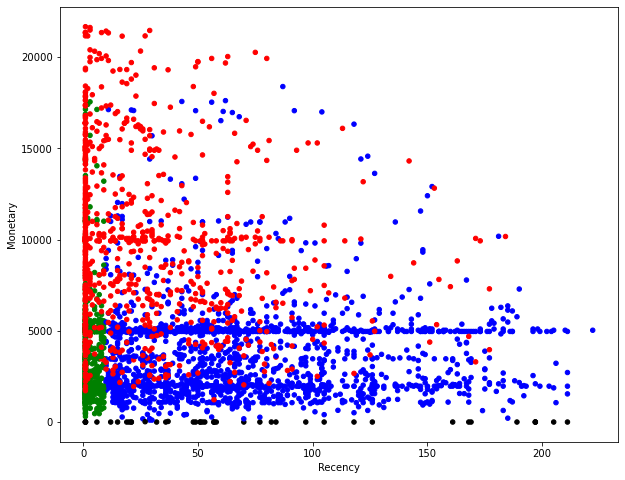

In [1328]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue", 'black']
rfm_table['Color'] =rfm_table['Cluster'].map(lambda p: Colors[p])
ax =rfm_table.plot(    
    kind="scatter", 
    x="Recency", y="Monetary",
    figsize=(10,8),
    c =rfm_table['Color']
)

In [1329]:
rfm_table.groupby('Cluster')['Monetary'].describe()

count         mean          std      min      25%     50%       75%  \
Cluster                                                                         
0         826.0  9716.403995  4691.859868  1222.12  6211.49  9563.5  12444.85   
1         880.0  3866.168693  2407.467866   307.00  1978.75  3616.0   4966.00   
2        1821.0  3865.239242  2467.780017   109.00  1966.00  3566.0   4966.00   
3          43.0     2.162791     5.541747     1.00     1.00     1.0      1.00   

              max  
Cluster            
0        21671.00  
1        17553.96  
2        18389.65  
3           33.00

In [1330]:
rfm_table.Monetary.sum()

18466671.81

In [1359]:
# density plot and ine plot

# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 11569095.100000001)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = rfm_table.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

Customers in cluster 3 are those Business is losing money on or not getting any profit, Cluster 0 are the most profitable customers with average recency

In [1351]:
#merge with application data
rfm = rfm_table[['clientID','Recency', 'Frequency', 'Monetary', 'Cluster']]
new = lite.merge(rfm, on='clientID')

#remove duplicates
new = new.drop_duplicates('clientID', keep='first')
new.shape

(3570, 42)

In [1354]:
summary_df =new.groupby('Cluster').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean, groupby_median],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean, groupby_median],
    'Income'  :[groupby_mean, groupby_median],
    'TimeEmploymentMM' : [groupby_mean, groupby_median],
    'TotalTimeAtAddress' : [groupby_mean, groupby_median],
    'LoanAmount' : [groupby_mean, groupby_median]
})

summary_df=summary_df.reset_index()
summary_df

Cluster clientID    Recency        Frequency   Monetary               \
             count        avg median       avg percentage          avg   
0       0      826  28.331719   16.5  2.314770       43.5  9716.403995   
1       1      880   2.426136    1.0  1.001136       18.4  3866.168693   
2       2     1821  71.087315   62.0  1.001098       38.1  3865.239242   
3       3       43  75.279070   53.0  1.558140        0.0     2.162791   

                  Income           TimeEmploymentMM        TotalTimeAtAddress  \
   median            avg    median              avg median                avg   
0  9563.5  262929.006223  130000.0        67.475787     51         180.489104   
1  3616.0  438919.428591  110000.0        64.892045     48         180.293182   
2  3566.0  291198.027683  120000.0        68.796815     50         174.756727   
3     1.0  172163.627907  100000.0        64.023256     39         170.511628   

            LoanAmount           
  median           avg   median  
0  104.0  19464.473995  20000.0  
1  120.0  19663.181818  20000.0  
2  100.0  18912.344865  20000.0  
3   98.0  18453.488372  18100.0

In [1356]:
new.groupby('Cluster').AddresLGA.describe()

count unique              top freq
Cluster                                   
0         824    108  Abuja Municipal   64
1         878    107         Alimosho   66
2        1789    125         Alimosho  142
3          43     27            Abaji    6

# RFM clustering function

# K-Means Clustering with Application Data

## July

In [648]:
jul = Lite[Lite['Closeddate']<='2021-07-31']
jul= jul[jul['AccountState']=='CLOSED']
jul= jul[~(jul['DisbMonth'].isna())]

#filter neeeded fileds from rfm_table
rfm = july_rfm[['clientID', 'Recency', 'Frequency','Monetary']]

#merge
data = jul.merge(rfm, on='clientID')
data.head()

LoanId AccountState AccountSubstate CreationDate DisbursementDate  \
0  92038233       CLOSED             NaN   2021-05-15       2021-05-15   
1  92043589       CLOSED             NaN   2021-05-25       2021-05-25   
2  92029219       CLOSED             NaN   2021-04-24       2021-04-24   
3  92043620       CLOSED             NaN   2021-05-25       2021-05-26   
4  92043695       CLOSED             NaN   2021-05-25       2021-05-30   

    DisbMonth  Age          DocumentType  DTI EducationStatus   EmployerLGA  \
0  2021-05-01   25  Voters Identity Card  0.0       Secondary  Amuwo-Odofin   
1  2021-05-01   43       Drivers License  0.0        Graduate   Akure South   
2  2021-04-01   43       Drivers License  0.0        Graduate   Akure South   
3  2021-05-01   24                   BVN  0.0        Graduate      Alimosho   
4  2021-05-01   43                   NaN  0.0        Graduate         Agege   

  EmployerState  Gender    Income  LoanAmount MaritalStatus  NoChildren  \
0         Lagos    MALE   40000.0      6800.0        Single           0   
1          Ondo    MALE   40000.0     20000.0       Married           2   
2          Ondo    MALE  120000.0     10400.0       Married           2   
3         Lagos  FEMALE  100000.0     15000.0        Single           0   
4         Lagos    MALE  150000.0     20000.0        Single           0   

   RepaymentBank         AddresLGA ResidentialStatus  TimeEmploymentMM  \
0    Access Bank  Ajeromi-Ifelodun           Renting                29   
1            UBA       Akure South             Owner               111   
2            UBA       Akure South             Owner               109   
3  Fidelity Bank      Oshodi-Isolo    With Relatives                17   
4        GT Bank      Amuwo-Odofin           Renting               162   

   TotalTimeAtAddress    BusinessSector EmploymentPosition GBFlag  MaxDPD  \
0               318.0     Manufacturing                NaN   Good    -2.0   
1               222.0       Agriculture                NaN   Good     0.0   
2               222.0       Agriculture                NaN   Good    -8.0   
3               196.0  Industrial Goods                NaN   Good   -24.0   
4               146.0          Services                NaN   Good    -4.0   

  (DueDate) FPD        FPD  Closeddate MaturityDate  EarlySettlementFlg  \
0    2021-06-14  PAID IN 7  2021-06-12   2021-07-14                   1   
1    2021-06-24  PAID IN 7  2021-06-24   2021-07-24                   1   
2    2021-05-24  PAID IN 7  2021-05-16   2021-06-23                   1   
3    2021-06-25  PAID IN 7  2021-06-01   2021-07-25                   1   
4    2021-06-29  PAID IN 7  2021-06-25   2021-08-28                   1   

    WeekDay  DayOfTheMonth timeindayselect MobileNetwork   Channels  \
0  Saturday             15       6am - 8am           GLO  Renmobile   
1   Tuesday             25     10am - 12pm           MTN  Renmobile   
2  Saturday             24      8am - 10am           MTN  Renmobile   
3   Tuesday             25     10am - 12pm       9mobile  Renmobile   
4   Tuesday             25      12pm - 2pm       9mobile  Renmobile   

      clientID  Recency  Frequency  Monetary  
0  22255490492        6          1   1303.00  
1  22243090415        3          2   7052.00  
2  22243090415        3          2   7052.00  
3  22159134290       13          1   3316.00  
4  22293284211       36          2  13971.98

In [649]:
data.isna().sum()

LoanId                   0
AccountState             0
AccountSubstate       3116
CreationDate             0
DisbursementDate         0
DisbMonth                0
Age                      0
DocumentType           729
DTI                      0
EducationStatus          0
EmployerLGA             59
EmployerState            7
Gender                   0
Income                   0
LoanAmount               0
MaritalStatus            0
NoChildren               0
RepaymentBank            0
AddresLGA               36
ResidentialStatus       62
TimeEmploymentMM         0
TotalTimeAtAddress       0
BusinessSector           0
EmploymentPosition    2880
GBFlag                   0
MaxDPD                   0
(DueDate) FPD            0
FPD                      0
Closeddate               0
MaturityDate             0
EarlySettlementFlg       0
WeekDay                  0
DayOfTheMonth            0
timeindayselect          0
MobileNetwork            0
Channels                 0
clientID                 0
R

In [650]:
#drop fields with too many missing values

miss = [i for i in data.columns if data[i].isna().sum() >= 0.7*len(data[i])]
data = data.drop(miss, axis=1)


#drop duplicate data points

data = data.drop_duplicates(subset='clientID', keep = 'first')
data.shape

(2586, 38)

In [651]:
data.drop(['CreationDate', 'DisbursementDate',
       'DisbMonth','GBFlag','EarlySettlementFlg','Closeddate', 'MaturityDate' ,'(DueDate) FPD', 'FPD', 'DocumentType', 'DTI', 'LoanId','LoanAmount','MaxDPD', 'AccountState', 'RepaymentBank'], axis=1, inplace=True)

#fill missing values
data['AddresLGA'].fillna(data['AddresLGA'].mode()[0], inplace=True)
data['EmployerLGA'].fillna(data['EmployerLGA'].mode()[0], inplace=True)
data['EmployerState'].fillna(data['EmployerState'].mode()[0], inplace=True)
data['ResidentialStatus'].fillna(data['ResidentialStatus'].mode()[0], inplace=True)

In [652]:
#set clientID as index
data.set_index('clientID', inplace=True)

## treating categorical variables

In [653]:
#mapping the unique categorical values to 0 and 1
gender= {'MALE':0, 'FEMALE':1}
data['Gender']= data['Gender'].map(gender)

In [654]:
# LGA in each state
FCT = [
    'Gwagwalada',
    'Kuje',
    'Abaji',
    'Abuja Municipal',
    'Bwari',
    'Kwali'
]

Rivers=['Eleme', 'Port Harcourt']

lagos_mainland = [
    'Alimosho',
    'Ikorodu',
    'Agege',
    'Kosofe',
    'Ifako-Ijaye',
    'Lagos Mainland',
    'Ikeja',
    'Oshodi-Isolo',
    'Surulere',
    'Shomolu',
    'Amuwo-Odofin',
    'Ojo',
    'Mushin',
    'Apapa',
    'Badagry',
    'Ajeromi-Ifelodun',
    'Egbeda',
]

lagos_island = [
    'Eti-Osa',
    'Ibeju/Lekki',
    'Eti Osa',
    'Lagos Island',
    'Epe',
]

# Regroup Address LGA
data['Address_LGA'] = np.where(
    data['AddresLGA'].isin(FCT), 'FCT', np.where(
    data['AddresLGA'].isin(lagos_mainland), 'Lagos Mainland', np.where(
    data['AddresLGA'].isin(lagos_island), 'Lagos Island', np.where(
    data['AddresLGA'].isin(Rivers), 'Rivers','Others'))))

data['Address_LGA'].value_counts()

Lagos Mainland    1090
Others             712
FCT                419
Lagos Island       194
Rivers             171
Name: Address_LGA, dtype: int64

In [655]:
# Regroup Employer's LGA
data['Employer_LGA'] = np.where(
    data['EmployerLGA'].isin(FCT), 'FCT', np.where(
    data['EmployerLGA'].isin(lagos_mainland), 'Lagos Mainland', np.where(
    data['EmployerLGA'].isin(lagos_island), 'Lagos Island',np.where(
    data['EmployerLGA'].isin(Rivers), 'Rivers','Others'))))

data['Employer_LGA'].value_counts()

Lagos Mainland    991
Others            626
FCT               546
Lagos Island      280
Rivers            143
Name: Employer_LGA, dtype: int64

## Bivariate analysis of numerica variables

Text(0.5, 1.0, 'Scatter plot between Age and Income')

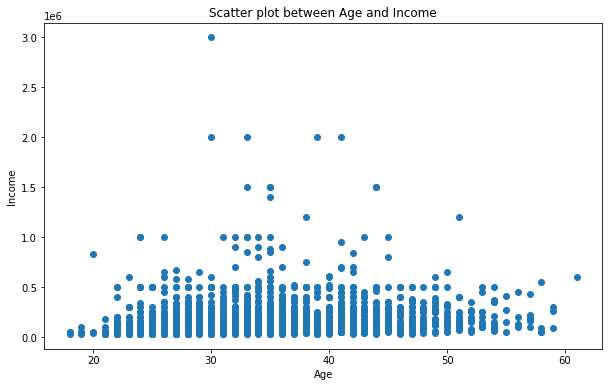

In [635]:
plt.figure(figsize=(10,6))
plt.scatter(data['Age'],data['Income'], marker='o');
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Scatter plot between Age and Income')


Text(0.5, 1.0, 'Scatter plot between Age and T')

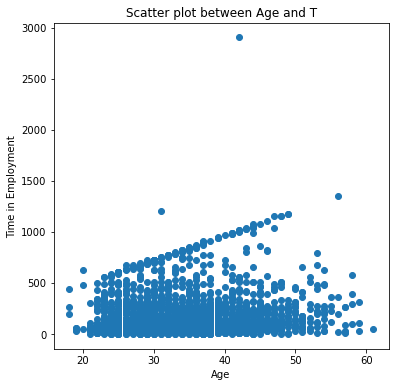

In [527]:
plt.figure(figsize=(6,6))
plt.scatter(data['Age'],data['TotalTimeAtAddress'], marker='o');
plt.xlabel('Age')
plt.ylabel('Time in Employment')
plt.title('Scatter plot between Age and T')

Text(0.5, 1.0, 'Scatter plot between Age and T')

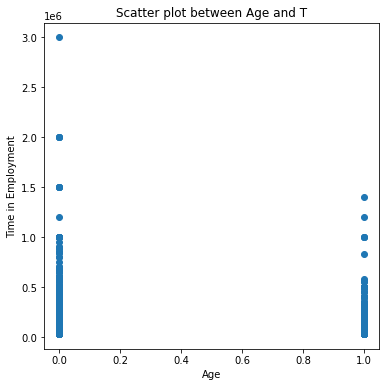

In [529]:
plt.figure(figsize=(6,6))
plt.scatter(data['Gender'],data['Income'], marker='o');
plt.xlabel('Age')
plt.ylabel('Time in Employment')
plt.title('Scatter plot between Age and T')

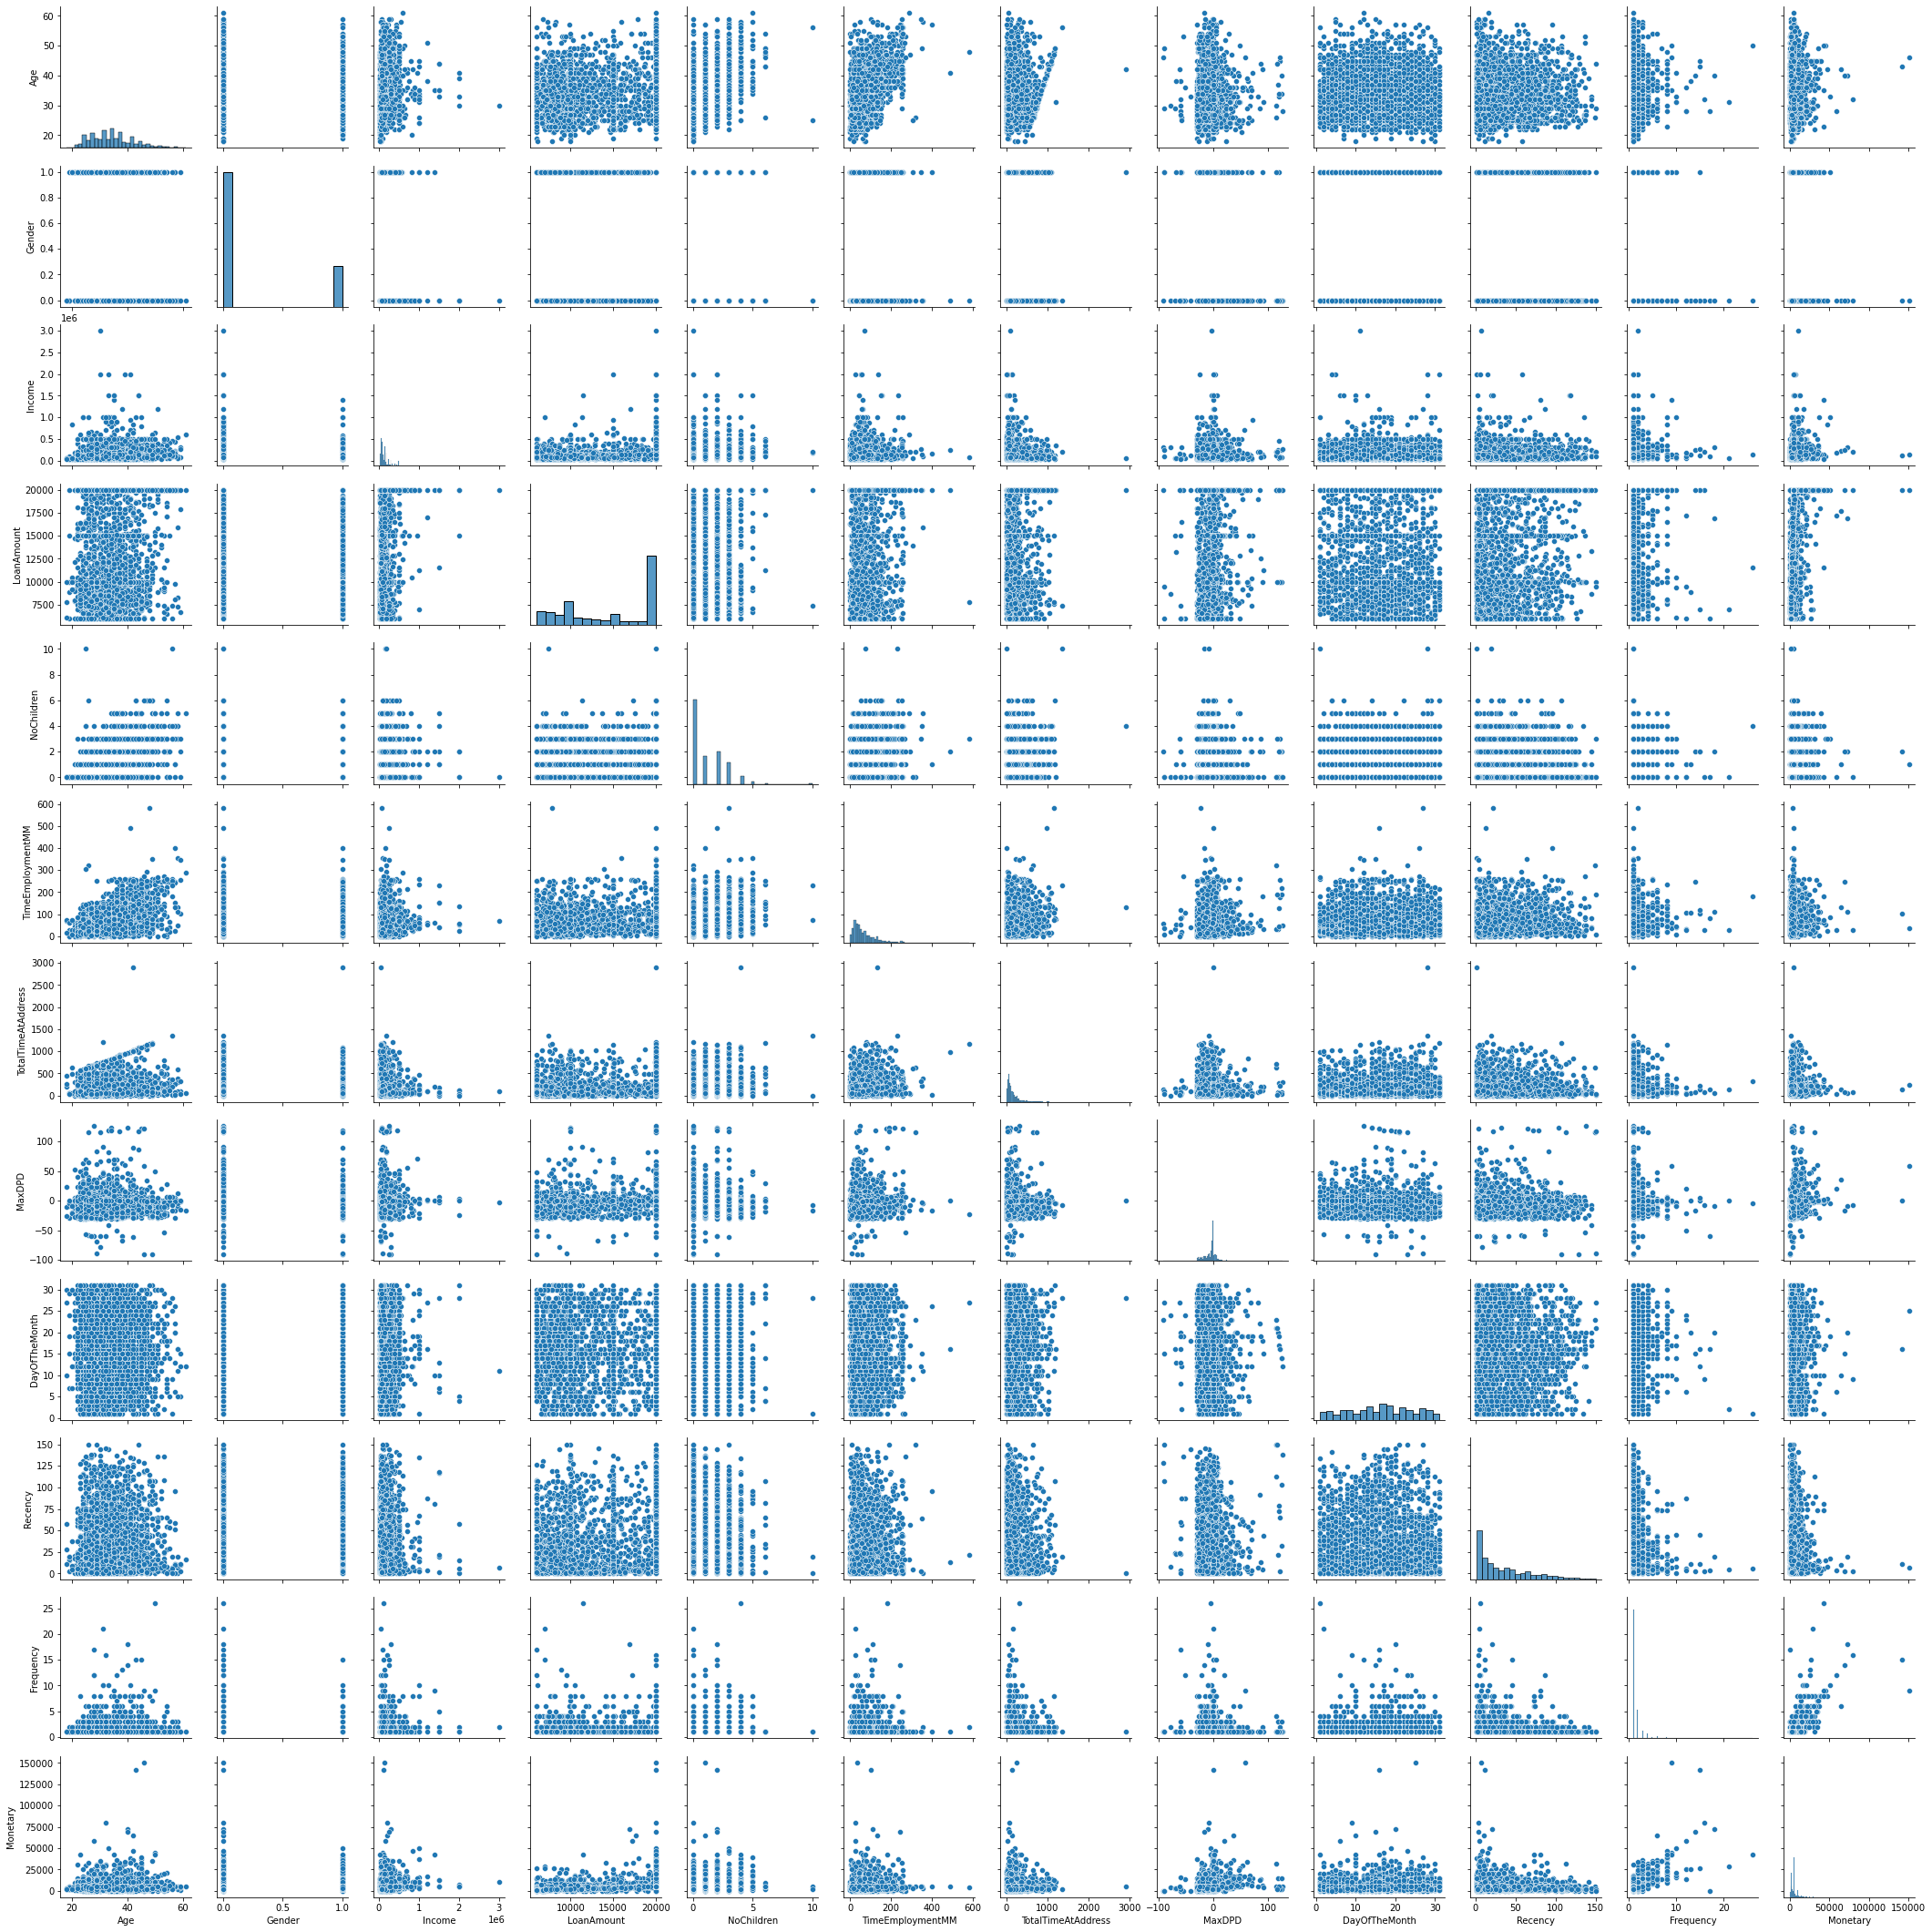

In [495]:


sns.pairplot(data)

In [636]:
data.drop(['AddresLGA', 'EmployerLGA', 'EmployerState'], axis=1, inplace=True)

<AxesSubplot:>

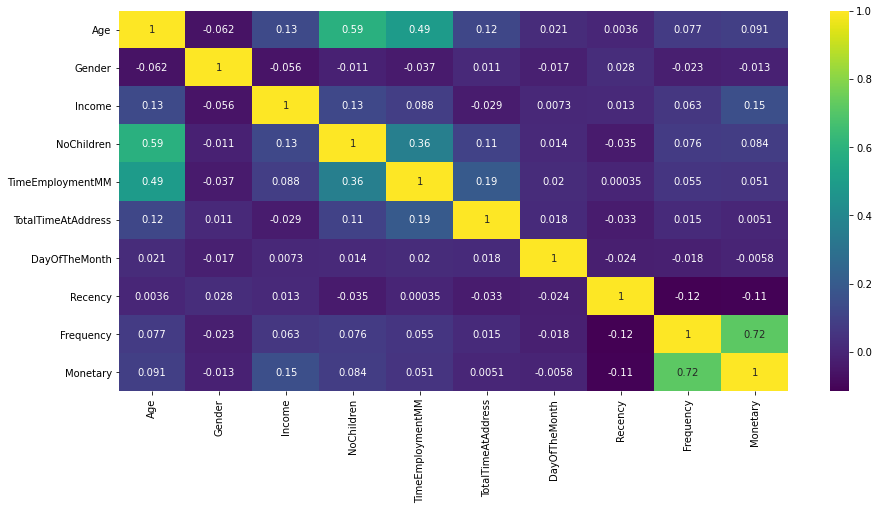

In [530]:
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.corr(), annot=True, cmap='viridis')

## standardzing the feature

In [656]:
num= data.select_dtypes(['float64', 'int64'])
#standard scaling the features to bring them around the same scale
scaler = StandardScaler()
data1[num.columns] = scaler.fit_transform(data[num.columns])
data1 = pd.get_dummies(data)
data1.shape

(2586, 379)

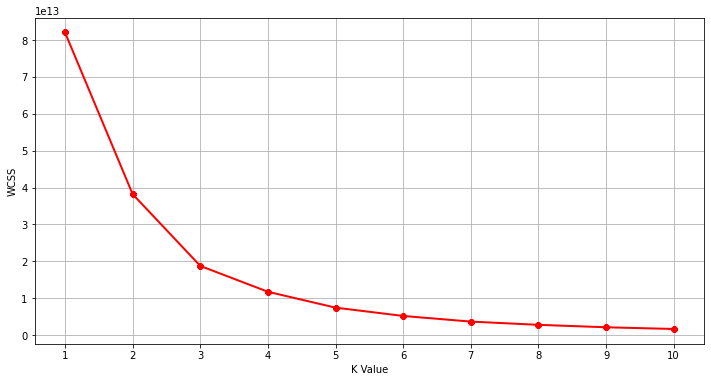

In [657]:
x= data1.copy

# Create an object (which we would call kmeans)
# The number in the brackets is K, or the number of clusters we are aiming for
kmeans = KMeans(3)

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [540]:
#Finding out the silhouette score to see if we have built a good model
#print(silhouette_score(clusters, kmeans.labels_, metric='euclidean'))

In [669]:
#assign the optimal number of clusters as 5
kmeans_new = KMeans(3)
# Fit the data
kmeans_new.fit(data1)
# Create a new data frame with the predicted clusters
clusters_new = data1.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(data1)

#mapping the gender variable back to 'male' and 'female'
gender= {0:'Male',1:'Female'}
clusters_new['Gender']= clusters_new['Gender'].map(gender)

In [670]:
# merge with main data 
new =pd.merge(data, clusters_new[['cluster_pred']], left_index=True, right_index=True)

In [671]:
new.head()

Age EducationStatus      EmployerLGA EmployerState  Gender  \
clientID                                                                  
22255490492   25       Secondary     Amuwo-Odofin         Lagos       0   
22243090415   43        Graduate      Akure South          Ondo       0   
22159134290   24        Graduate         Alimosho         Lagos       1   
22293284211   43        Graduate            Agege         Lagos       0   
22245652590   45        Graduate  Abuja Municipal           FCT       0   

               Income MaritalStatus  NoChildren         AddresLGA  \
clientID                                                            
22255490492   40000.0        Single           0  Ajeromi-Ifelodun   
22243090415   40000.0       Married           2       Akure South   
22159134290  100000.0        Single           0      Oshodi-Isolo   
22293284211  150000.0        Single           0      Amuwo-Odofin   
22245652590  126000.0       Married           1        Gwagwalada   

            ResidentialStatus  TimeEmploymentMM  TotalTimeAtAddress  \
clientID                                                              
22255490492           Renting                29               318.0   
22243090415             Owner               111               222.0   
22159134290    With Relatives                17               196.0   
22293284211           Renting               162               146.0   
22245652590           Renting                25                49.0   

               BusinessSector   WeekDay  DayOfTheMonth timeindayselect  \
clientID                                                                 
22255490492     Manufacturing  Saturday             15       6am - 8am   
22243090415       Agriculture   Tuesday             25     10am - 12pm   
22159134290  Industrial Goods   Tuesday             25     10am - 12pm   
22293284211          Services   Tuesday             25      12pm - 2pm   
22245652590        Government   Tuesday             22      12pm - 2pm   

            MobileNetwork   Channels  Recency  Frequency  Monetary  \
clientID                                                             
22255490492           GLO  Renmobile        6          1   1303.00   
22243090415           MTN  Renmobile        3          2   7052.00   
22159134290       9mobile  Renmobile       13          1   3316.00   
22293284211       9mobile  Renmobile       36          2  13971.98   
22245652590           MTN    Web App        2          1   1966.00   

                Address_LGA    Employer_LGA  cluster_pred  
clientID                                                   
22255490492  Lagos Mainland  Lagos Mainland             0  
22243090415          Others          Others             0  
22159134290  Lagos Mainland  Lagos Mainland             0  
22293284211  Lagos Mainland  Lagos Mainland             0  
22245652590             FCT             FCT             0

In [672]:
new.cluster_pred.value_counts()

0    2122
2     429
1      35
Name: cluster_pred, dtype: int64

Text(0, 0.5, 'Monetary')

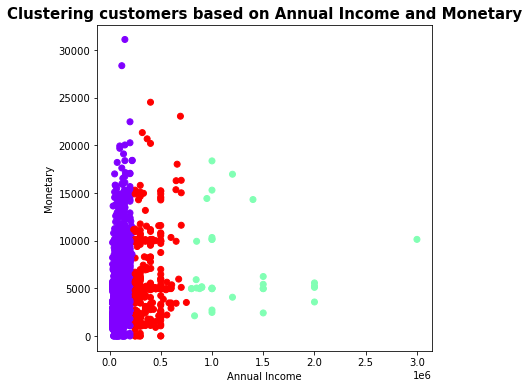

In [673]:
plt.figure(figsize=(6,6))
plt.scatter(new['Income'],new['Monetary'],c=new['cluster_pred'],cmap='rainbow')
plt.title("Clustering customers based on Annual Income and Monetary", fontsize=15,fontweight="bold")
plt.xlabel("Annual Income")
plt.ylabel("Monetary")

the lowe income earners are the most profitable to Business

In [674]:
#To compare attributes of the different clusters, lets find the average of all variables across each cluster
avg_data = new.groupby(['cluster_pred'], as_index=False).mean()
avg_data

cluster_pred        Age    Gender        Income  NoChildren  \
0             0  33.789821  0.242696  1.045529e+05    1.072573   
1             1  35.285714  0.171429  1.223017e+06    1.485714   
2             2  36.638695  0.193473  3.605040e+05    1.538462   

   TimeEmploymentMM  TotalTimeAtAddress  DayOfTheMonth    Recency  Frequency  \
0         67.289821          175.196984      16.019793  33.329406   1.232799   
1         80.685714          130.742857      16.628571  33.342857   1.371429   
2         78.613054          171.533800      16.261072  38.172494   1.230769   

      Monetary  
0  4399.099486  
1  7028.617714  
2  5687.234476

In [675]:
#see details of the clusters
new.groupby('cluster_pred')['AddresLGA'].describe()

count unique              top freq
cluster_pred                                   
0             2122    127         Alimosho  188
1               35     18          Ikorodu    4
2              429     71  Abuja Municipal   41

In [313]:
#filter accounts not disbursed to
jul = lite[~(lite['DisbMonth'].isna())]
lite = lite[lite['AccountState'].isin(['CLOSED'])]


lite = lite[['clientID', 'Age', 'EducationStatus', 'Gender', 'Income', 'MaritalStatus', 'TimeEmploymentMM', 'TotalTimeAtAddress']]
# Drop Duplicate information in the dataset

lite.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)
# Encode for string labels


#filter neeeded fileds from rfm_table
rfm = rfm_table[['clientID', 'Recency', 'Frequency','Monetary']]

#merge
data = lite.merge(rfm, on='clientID', keep = 'first', inplace = True)
data.head()

clientID  Age EducationStatus  Gender    Income MaritalStatus  \
0  22255490492   25       Secondary    MALE   40000.0        Single   
1  22243090415   43        Graduate    MALE   40000.0       Married   
2  22159134290   24        Graduate  FEMALE  100000.0        Single   
3  22293284211   43        Graduate    MALE  150000.0        Single   
4  22245652590   45        Graduate    MALE  126000.0       Married   

   TimeEmploymentMM  TotalTimeAtAddress  Recency  Frequency  Monetary  
0                29               318.0       43          1   1303.00  
1               111               222.0       37          2   7052.00  
2                17               196.0       60          1   3316.00  
3               162               146.0       36          2  13971.98  
4                25                49.0       30          1   1966.00

In [315]:

#standardize
standard_normalized_vars(data[['Income', 'TimeEmploymentMM', 'TotalTimeAtAddress', 'Monetary', 'Recency']])
#convert categorical columns to numerical
data = pd.get_dummies(data)

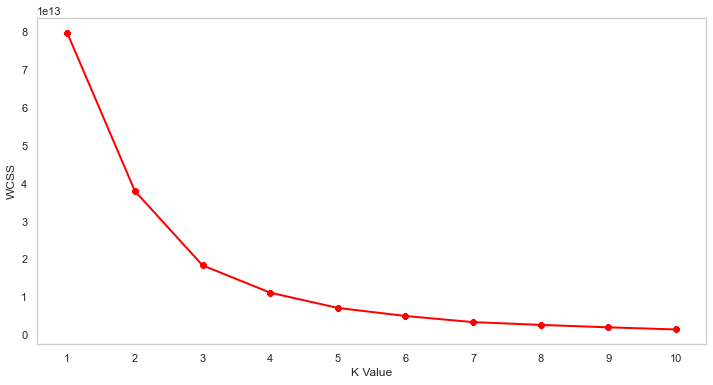

In [316]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

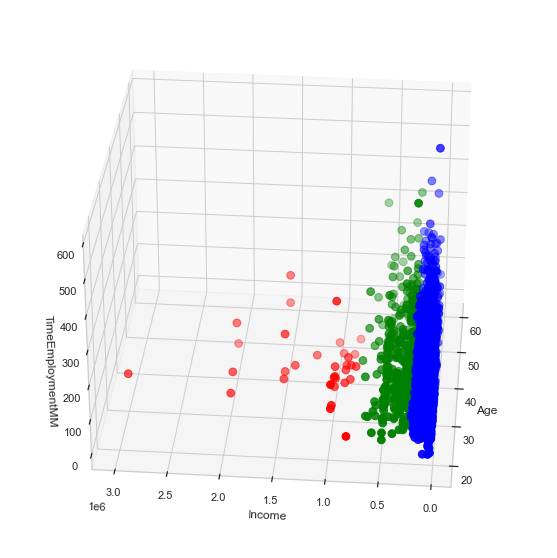

In [258]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data.iloc[:,1:])
data["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D

 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Age[data.label == 0], data["Income"][data.label == 0], data["TimeEmploymentMM"][data.label == 0], c='blue', s=60)
ax.scatter(data.Age[data.label == 1], data["Income"][data.label == 1], data["TimeEmploymentMM"][data.label == 1], c='red', s=60)
ax.scatter(data.Age[data.label == 2], data["Income"][data.label == 2], data["TimeEmploymentMM"][data.label == 2], c='green', s=60)
#ax.scatter(data.Age[data.label == 3], data["Income"][data.label == 3], data["TimeEmploymentMM"][data.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Income")
ax.set_zlabel('TimeEmploymentMM')
plt.show()

In [259]:
data.label.value_counts()

0    2167
2     433
1      33
Name: label, dtype: int64

# Customer Lifetime Values
Using the **Beta-Geometric/Negative Binomial Distribution** a Buy-til-You-Die Model for predicting Customer Lifetime Value

In [103]:
# Install lifetimes
#!pip install lifetimes
!pip install lifetimes
!pip install openpyxl

  Using cached Lifetimes-0.11.3-py3-none-any.whl (584 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached autograd-1.3-py3-none-any.whl


In [192]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

## preparing dataset to calculate CLV

In [193]:
latest_date = dt.datetime(2021, 7, 31)

clv = rfm_table[['clientID', 'Recency', 'Frequency', 'Monetary', 'T']]
clv.tail()

clientID  Recency  Frequency  Monetary    T
2654  22300266654       62          3   8775.00  103
2655  22306062513       46          3  12752.16  160
2656  22332880026       44          3  10792.00  162
2658  22385887199       47          3  13703.00  124
2659  22408493662       69          3  15231.33  135

In [194]:
# in this case we will suppose that monetary value is average earning per transaction
clv['Monetary'] = clv['Monetary'] / clv['Frequency']

# transforming days to weeks
div = 7
clv['Recency'] = clv['Recency'] / div
clv['T'] = clv['T'] / div
clv.tail()

clientID   Recency  Frequency     Monetary          T
2654  22300266654  8.857143          3  2925.000000  14.714286
2655  22306062513  6.571429          3  4250.720000  22.857143
2656  22332880026  6.285714          3  3597.333333  23.142857
2658  22385887199  6.714286          3  4567.666667  17.714286
2659  22408493662  9.857143          3  5077.110000  19.285714

## Creating BG-NBD Model

In [195]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv['Frequency'], clv['Recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 2633 subjects, a: 2.99, alpha: 18.51, b: 0.91, r: 3.73>

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

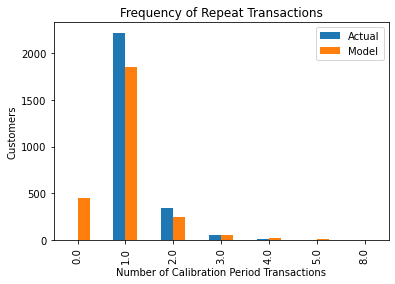

In [196]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [197]:
# Top 10 customers expected to make the most purchases in a week
bgf.conditional_expected_number_of_purchases_up_to_time(1, # week
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

2302    0.066534
2214    0.060636
1574    0.051634
386     0.051634
525     0.050545
1470    0.049899
338     0.048823
2343    0.047841
1512    0.047531
363     0.047531
dtype: float64

In [198]:
# Top 10 customers expected to make the most purchases in a month
bgf.conditional_expected_number_of_purchases_up_to_time(4, # 4 weeks = 1 month
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

2302    0.221293
2214    0.210549
386     0.163293
1574    0.163293
2343    0.162985
525     0.159605
2314    0.159448
1470    0.158042
338     0.154403
2332    0.153970
dtype: float64

In [190]:
# Top 10 customers expected to make the most purchases in next 6 months
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6, # weeks * count = months
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

1204    1.939634
2363    1.534054
2589    1.487005
2369    1.454968
2366    1.430812
2342    1.418584
2602    1.361618
2604    1.359545
2204    1.351393
2265    1.348394
dtype: float64

In [199]:
# The count of total transactions expected in next 6 months
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sum()

414.0555854217395

## Gamma Gamma model for monetary value

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [200]:

rfm_table[['Monetary', 'Frequency']].corr()


Monetary  Frequency
Monetary   1.000000   0.566945
Frequency  0.566945   1.000000

the model won't be accurate since the 2 vectors isn't close to 0, but let's go ahead and confirm

In [202]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(clv['Frequency'], clv['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2633 subjects, p: 2.69, q: 0.17, v: 2.64>

In [203]:
# The top 10 customers expected to be most valuable
ggf.conditional_expected_average_profit(clv['Frequency'],
                                        clv['Monetary']).sort_values(ascending=False).head(10)

2397    22004.030739
2412    21551.036012
2439    21530.128118
2433    21058.999730
2401    20865.092383
2452    20838.101405
2435    20647.156129
2384    20299.062098
2438    19698.556184
2381    19520.253899
dtype: float64

## Predicting Customer lifetime value

In [211]:
# The customers' lifetime values expected to in the next 3 months
clv['clv_pred_1_months'] = ggf.customer_lifetime_value(bgf,
                                   clv['Frequency'],
                                   clv['Recency'],
                                   clv['T'],
                                   clv['Monetary'],
                                   time=1,  # 3 months
                                   freq="W"  # frequency information of T. In this case we set week by using 'W'
                                   )
clv

clientID    Recency  Frequency     Monetary          T  \
0     22141758042  12.142857          1  3374.000000  16.571429   
1     22142274105  17.571429          1  3466.000000  20.714286   
2     22142501225  11.571429          1  2762.000000  19.571429   
3     22143621326  17.142857          1  2095.000000  21.428571   
4     22144775491  20.571429          1  3399.000000  21.285714   
...           ...        ...        ...          ...        ...   
2654  22300266654   8.857143          3  2925.000000  14.714286   
2655  22306062513   6.571429          3  4250.720000  22.857143   
2656  22332880026   6.285714          3  3597.333333  23.142857   
2658  22385887199   6.714286          3  4567.666667  17.714286   
2659  22408493662   9.857143          3  5077.110000  19.285714   

      clv_pred_3_months  clv_pred_1_months  
0            690.428905         321.598340  
1            816.132114         370.208532  
2            353.091900         161.271459  
3            433.420040         195.792965  
4           1018.086451         460.286607  
...                 ...                ...  
2654        1040.773587         485.262961  
2655         206.338429          91.476865  
2656         154.268667          68.290900  
2658         581.314911         265.520016  
2659         991.958815         448.676913  

[2633 rows x 7 columns]

## comparing predicted 1 month clv with the actual

In [212]:
#get clientID from the august data
aug_id = rfm_aug.clientID.values

#get the clientIDs in aug data
aug = clv[clv['clientID'].isin(aug_id)]

#abut 214 customers returned for a loan in august, the rest were new customers

#merge 
test = aug.merge(rfm_aug, on='clientID')
test.head()

clientID    Recency  Frequency_x  Monetary_x          T  \
0  22173411072  11.571429            1      3055.0  15.857143   
1  22177238237  11.428571            1      2462.0  12.142857   
2  22186056611  13.428571            1      2746.0  18.571429   
3  22194129626  11.571429            1      3646.0  14.571429   
4  22281385861  16.857143            1      2026.0  20.142857   

   clv_pred_3_months  clv_pred_1_months  Frequency_y  Monetary_y  
0         637.062776         298.242917            1     2086.00  
1         838.420787         404.056344            1     3496.00  
2         513.264248         235.904463            1     2554.00  
3         904.996317         427.718483            1     5032.67  
4         471.561853         214.634539            1    12372.24

Comparing the predicted values with the actual , we can see the model is inaccurate